In [1]:
from keras.models import Model
from keras.layers import Add, concatenate, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, TimeDistributed, LSTM
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
import numpy as np
import os
import cv2
from keras.applications.mobilenet import MobileNet
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.losses import mean_squared_error

from preprocessing import BatchGenerator
from preprocessing_seq import BatchGeneratorVideo
from backend import TinyYoloFeature, FullYoloFeature, MobileNetFeature, SqueezeNetFeature, Inception3Feature, VGG16Feature, ResNet50Feature
from utils import decode_netout, compute_overlap, compute_ap

from keras import backend as K
K.set_learning_phase(1) 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import argparse
import os
import numpy as np
from preprocessing import parse_annotation
import json

from lstm import TT_LSTM

In [164]:
class YOLO(object):
    def __init__(self, backend,
                       input_size, 
                       labels, 
                       max_box_per_image,
                       anchors,
                       tt_input_shape = None,
                       pretrained_weights=None):
        
        self.sequence_length = 8
        self.batch_size = 2

        self.curves = dict()
        self.curves['consistency'] = []
        self.curves['yolo'] = []
        self.curves['all'] = []

        yolo_detection_model = self.get_yolo_model(backend,
                       input_size, 
                       labels, 
                       max_box_per_image,
                       anchors,
                       pretrained_weights)
        
        yolo_detection_model.trainable = False
        
        input_image     = Input(shape=(self.sequence_length, self.input_size, self.input_size, 3))
        self.true_boxes = Input(shape=(self.sequence_length, 1, 1, 1, max_box_per_image , 4))
        
        
        flatten_size = self.grid_h * self.grid_w * self.nb_box * (4 + 1 + self.nb_class)
        
        y_detection = TimeDistributed(yolo_detection_model)(input_image)
        detection = Reshape((self.sequence_length, flatten_size))(y_detection)
        
        tt_output_shape = tt_input_shape
        print('flatten size', flatten_size)
        
        assert flatten_size == np.prod(tt_input_shape), "wrong tt input shape"
        
        detection = TT_LSTM(row_dims=tt_input_shape,
                            column_dims=tt_output_shape,
                            tt_rank=4,
                            return_sequences=True,
                            dropout=0.25, recurrent_dropout=0.25, activation='tanh')(detection)
        
        l_detection = Reshape((self.sequence_length, self.grid_h, self.grid_w, self.nb_box * (4 + 1 + self.nb_class)))(detection)
        
        res_maps = Add()([y_detection, l_detection])
        
#        final_conv_layer = Conv2D(self.nb_box * (4 + 1 + self.nb_class), 
#                        (1,1), strides=(1,1), 
#                        padding='same', 
#                        name='FinalDetectionLayer', 
#                        kernel_initializer='lecun_normal')
        
#        final_detection = TimeDistributed(final_conv_layer)(res_maps)

        # make the object detection layer
        output = Reshape((self.sequence_length, self.grid_h, self.grid_w, self.nb_box, 4 + 1 + self.nb_class))(res_maps)
        output = Lambda(lambda args: args[0])([output, self.true_boxes])

        self.model = Model([input_image, self.true_boxes], output)

        # print a summary of the whole model
        self.model.summary()
        
    def get_yolo_model(self, backend,
                       input_size, 
                       labels, 
                       max_box_per_image,
                       anchors, weights_pretrained=None):
        self.input_size = input_size
        
        self.labels   = list(labels)
        self.nb_class = len(self.labels)
        self.nb_box   = len(anchors)//2
        self.class_wt = np.ones(self.nb_class, dtype='float32')
        self.anchors  = anchors

        self.max_box_per_image = max_box_per_image

        ##########################
        # Make the model
        ##########################

        # make the feature extractor layers
        input_image     = Input(shape=(self.input_size, self.input_size, 3))
        true_boxes      = Input(shape=(1, 1, 1, max_box_per_image , 4))

        if backend == 'Inception3':
            self.feature_extractor = Inception3Feature(self.input_size)  
        elif backend == 'SqueezeNet':
            self.feature_extractor = SqueezeNetFeature(self.input_size)        
        elif backend == 'MobileNet':
            self.feature_extractor = MobileNetFeature(self.input_size)
        elif backend == 'Full Yolo':
            self.feature_extractor = FullYoloFeature(self.input_size)
        elif backend == 'Tiny Yolo':
            self.feature_extractor = TinyYoloFeature(self.input_size)
        elif backend == 'VGG16':
            self.feature_extractor = VGG16Feature(self.input_size)
        elif backend == 'ResNet50':
            self.feature_extractor = ResNet50Feature(self.input_size)
        else:
            raise Exception('Architecture not supported! Only support Full Yolo, Tiny Yolo, MobileNet, SqueezeNet, VGG16, ResNet50, and Inception3 at the moment!')

        print(self.feature_extractor.get_output_shape())    
        self.grid_h, self.grid_w = self.feature_extractor.get_output_shape()        
        features = self.feature_extractor.extract(input_image)            

        # make the object detection layer
        detection_layer = Conv2D(self.nb_box * (4 + 1 + self.nb_class), 
                        (1,1), strides=(1,1), 
                        padding='same', 
                        name='DetectionLayer', 
                        kernel_initializer='lecun_normal')(features)
        output = Reshape((self.grid_h, self.grid_w, self.nb_box, 4 + 1 + self.nb_class))(detection_layer)
        output = Lambda(lambda args: args[0])([output, true_boxes])

        model = Model([input_image, true_boxes], output)
        if weights_pretrained:
            model.load_weights(weights_pretrained)
            
        detection_model = Model(input_image, detection_layer)
            
        return detection_model

    def consistency_loss(self, y_true, y_pred):
        loss = 0
        for i in range(self.sequence_length - 1):
            loss += K.mean(K.square(y_pred[:, i] - y_pred[:, i + 1]))
        loss /= self.sequence_length
        

        self.curves['consistency'].append(loss)
        
        return loss
    
    def yolo_loss(self, y_true, y_pred):
        loss = 0
        
        for i in range(self.sequence_length):
            loss += self.custom_loss(y_true[:, i], y_pred[:, i], self.true_boxes[:, i])
        loss /= self.sequence_length
        
        self.curves['yolo'].append(loss)
        
    
        
        return loss

    def custom_new_loss(self, y_true, y_pred):
        y_loss = self.yolo_loss(y_true, y_pred)
        c_loss = 1e-1 * self.consistency_loss(y_true, y_pred)
        
        loss = y_loss + c_loss
        
        self.curves['all'].append(loss)
        
        loss = tf.Print(loss, [c_loss], message='Consistency loss \t', summarize=1000)
        loss = tf.Print(loss, [y_loss], message='Mean overall loss \t', summarize=1000)
        loss = tf.Print(loss, [loss], message='Sequence loss \t', summarize=1000)
        
        return loss

    def custom_loss(self, y_true, y_pred, true_box):
        mask_shape = tf.shape(y_true)[:4]
        
        cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(self.grid_w), [self.grid_h]), (1, self.grid_h, self.grid_w, 1, 1)))
        cell_y = tf.transpose(cell_x, (0,2,1,3,4))

        cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [self.batch_size, 1, 1, self.nb_box, 1])
        
        coord_mask = tf.zeros(mask_shape)
        conf_mask  = tf.zeros(mask_shape)
        class_mask = tf.zeros(mask_shape)
        
        seen = tf.Variable(0.)
        total_recall = tf.Variable(0.)
        
        """
        Adjust prediction
        """
        ### adjust x and y      
        pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
        
        ### adjust w and h
        pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(self.anchors, [1,1,1,self.nb_box,2])
        
        ### adjust confidence
        pred_box_conf = tf.sigmoid(y_pred[..., 4])
        
        ### adjust class probabilities
        pred_box_class = y_pred[..., 5:]
        
        """
        Adjust ground truth
        """
        ### adjust x and y
        true_box_xy = y_true[..., 0:2] # relative position to the containing cell
        
        ### adjust w and h
        true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
        
        ### adjust confidence
        true_wh_half = true_box_wh / 2.
        true_mins    = true_box_xy - true_wh_half
        true_maxes   = true_box_xy + true_wh_half
        
        pred_wh_half = pred_box_wh / 2.
        pred_mins    = pred_box_xy - pred_wh_half
        pred_maxes   = pred_box_xy + pred_wh_half       
        
        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
        pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)
        
        true_box_conf = iou_scores * y_true[..., 4]
        
        ### adjust class probabilities
        true_box_class = tf.argmax(y_true[..., 5:], -1)
        
        """
        Determine the masks
        """
        ### coordinate mask: simply the position of the ground truth boxes (the predictors)
        coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * self.coord_scale
        
        ### confidence mask: penelize predictors + penalize boxes with low IOU
        # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
        true_xy = true_box[..., 0:2]
        true_wh = true_box[..., 2:4]
        
        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half
        
        pred_xy = tf.expand_dims(pred_box_xy, 4)
        pred_wh = tf.expand_dims(pred_box_wh, 4)
        
        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half    
        
        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)

        best_ious = tf.reduce_max(iou_scores, axis=4)
        conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * self.no_object_scale
        
        # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
        conf_mask = conf_mask + y_true[..., 4] * self.object_scale
        
        ### class mask: simply the position of the ground truth boxes (the predictors)
        class_mask = y_true[..., 4] * tf.gather(self.class_wt, true_box_class) * self.class_scale       
        
        """
        Warm-up training
        """
        no_boxes_mask = tf.to_float(coord_mask < self.coord_scale/2.)
        seen = tf.assign_add(seen, 1.)
        
        true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, self.warmup_batches+1), 
                              lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                       true_box_wh + tf.ones_like(true_box_wh) * \
                                       np.reshape(self.anchors, [1,1,1,self.nb_box,2]) * \
                                       no_boxes_mask, 
                                       tf.ones_like(coord_mask)],
                              lambda: [true_box_xy, 
                                       true_box_wh,
                                       coord_mask])
        
        """
        Finalize the loss
        """
        nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
        nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
        nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
        
        loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
        loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
        loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
        loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
        loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
        
        loss = tf.cond(tf.less(seen, self.warmup_batches+1), 
                      lambda: loss_xy + loss_wh + loss_conf + loss_class + 10,
                      lambda: loss_xy + loss_wh + loss_conf + loss_class)
        
        if self.debug:
            nb_true_box = tf.reduce_sum(y_true[..., 4])
            nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))
            
            current_recall = nb_pred_box/(nb_true_box + 1e-6)
            total_recall = tf.assign_add(total_recall, current_recall) 

#            loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
#            loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
#            loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
#            loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
#            loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
            loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
            loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
        
        return loss

    def load_weights(self, weight_path):
        self.model.load_weights(weight_path)
        
    def get_gen_config(self):
        generator_config = {
            'IMAGE_H'         : self.input_size, 
            'IMAGE_W'         : self.input_size,
            'GRID_H'          : self.grid_h,  
            'GRID_W'          : self.grid_w,
            'BOX'             : self.nb_box,
            'LABELS'          : self.labels,
            'CLASS'           : len(self.labels),
            'ANCHORS'         : self.anchors,
            'BATCH_SIZE'      : self.batch_size,
            'TRUE_BOX_BUFFER' : self.max_box_per_image,
        }  
        
        return generator_config
    
    def get_normalizer(self):
        return self.feature_extractor.normalize

    def train(self, train_imgs,     # the list of images to train the model
                    valid_imgs,     # the list of images used to validate the model
                    train_times,    # the number of time to repeat the training set, often used for small datasets
                    valid_times,    # the number of times to repeat the validation set, often used for small datasets
                    nb_epochs,      # number of epoches
                    learning_rate,  # the learning rate
                    batch_size,     # the size of the batch
                    warmup_epochs,  # number of initial batches to let the model familiarize with the new dataset
                    object_scale,
                    no_object_scale,
                    coord_scale,
                    class_scale,
                    saved_weights_name='best_weights.h5',
                    debug=False):     

        self.batch_size = 2

        self.object_scale    = object_scale
        self.no_object_scale = no_object_scale
        self.coord_scale     = coord_scale
        self.class_scale     = class_scale

        self.debug = debug

        ############################################
        # Make train and validation generators
        ############################################

        generator_config = {
            'IMAGE_H'         : self.input_size, 
            'IMAGE_W'         : self.input_size,
            'GRID_H'          : self.grid_h,  
            'GRID_W'          : self.grid_w,
            'BOX'             : self.nb_box,
            'LABELS'          : self.labels,
            'CLASS'           : len(self.labels),
            'ANCHORS'         : self.anchors,
            'BATCH_SIZE'      : self.batch_size,
            'TRUE_BOX_BUFFER' : self.max_box_per_image,
        }    

        train_generator = BatchGeneratorVideo(train_imgs, 
                                     generator_config, 
                                     norm=self.feature_extractor.normalize)
        valid_generator = BatchGeneratorVideo(valid_imgs, 
                                     generator_config, 
                                     norm=self.feature_extractor.normalize,
                                     jitter=False)   
                                     
        self.warmup_batches  = warmup_epochs * (train_times*len(train_generator) + valid_times*len(valid_generator))   

        ############################################
        # Compile the model
        ############################################

        optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        self.model.compile(loss=self.custom_new_loss, optimizer=optimizer)

        ############################################
        # Make a few callbacks
        ############################################

        early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)
        checkpoint = ModelCheckpoint(saved_weights_name, 
                                     monitor='val_loss', 
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='min', 
                                     period=1)
        tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/'), 
                                  histogram_freq=0, 
                                  write_graph=True, 
                                  write_images=False)

        ############################################
        # Start the training process
        ############################################        

        self.model.fit_generator(generator        = train_generator, 
                                 steps_per_epoch  = len(train_generator) * train_times, 
                                 epochs           = warmup_epochs + nb_epochs, 
                                 verbose          = 2 if debug else 1,
                                 validation_data  = valid_generator,
                                 validation_steps = len(valid_generator) * valid_times,
                                 callbacks        = [early_stop, checkpoint, tensorboard], 
                                 workers          = 6,
                                 max_queue_size   = 8)      

        ############################################
        # Compute mAP on the validation set
        ############################################
        #average_precisions = self.evaluate(valid_generator)     

        # print evaluation
        #for label, average_precision in average_precisions.items():
        #    print(self.labels[label], '{:.4f}'.format(average_precision))
        #print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions)))         

    def evaluate(self, 
                 generator, 
                 iou_threshold=0.3,
                 score_threshold=0.3,
                 max_detections=100,
                 save_path=None):
        """ Evaluate a given dataset using a given model.
        code originally from https://github.com/fizyr/keras-retinanet

        # Arguments
            generator       : The generator that represents the dataset to evaluate.
            model           : The model to evaluate.
            iou_threshold   : The threshold used to consider when a detection is positive or negative.
            score_threshold : The score confidence threshold to use for detections.
            max_detections  : The maximum number of detections to use per image.
            save_path       : The path to save images with visualized detections to.
        # Returns
            A dict mapping class names to mAP scores.
        """    
        # gather all detections and annotations
        all_detections     = [[None for i in range(generator.num_classes())] for j in range(generator.size())]
        all_annotations    = [[None for i in range(generator.num_classes())] for j in range(generator.size())]

        for i in range(generator.size()):
            raw_image = generator.load_image(i)
            raw_height, raw_width, raw_channels = raw_image.shape

            # make the boxes and the labels
            pred_boxes  = self.predict(raw_image)

            
            score = np.array([box.score for box in pred_boxes])
            pred_labels = np.array([box.label for box in pred_boxes])        
            
            if len(pred_boxes) > 0:
                pred_boxes = np.array([[box.xmin*raw_width, box.ymin*raw_height, box.xmax*raw_width, box.ymax*raw_height, box.score] for box in pred_boxes])
            else:
                pred_boxes = np.array([[]])  
            
            # sort the boxes and the labels according to scores
            score_sort = np.argsort(-score)
            pred_labels = pred_labels[score_sort]
            pred_boxes  = pred_boxes[score_sort]
            
            # copy detections to all_detections
            for label in range(generator.num_classes()):
                all_detections[i][label] = pred_boxes[pred_labels == label, :]
                
            annotations = generator.load_annotation(i)
            
            # copy detections to all_annotations
            for label in range(generator.num_classes()):
                all_annotations[i][label] = annotations[annotations[:, 4] == label, :4].copy()
                
        # compute mAP by comparing all detections and all annotations
        average_precisions = {}
        
        for label in range(generator.num_classes()):
            false_positives = np.zeros((0,))
            true_positives  = np.zeros((0,))
            scores          = np.zeros((0,))
            num_annotations = 0.0

            for i in range(generator.size()):
                detections           = all_detections[i][label]
                annotations          = all_annotations[i][label]
                num_annotations     += annotations.shape[0]
                detected_annotations = []

                for d in detections:
                    scores = np.append(scores, d[4])

                    if annotations.shape[0] == 0:
                        false_positives = np.append(false_positives, 1)
                        true_positives  = np.append(true_positives, 0)
                        continue

                    overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
                    assigned_annotation = np.argmax(overlaps, axis=1)
                    max_overlap         = overlaps[0, assigned_annotation]

                    if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                        false_positives = np.append(false_positives, 0)
                        true_positives  = np.append(true_positives, 1)
                        detected_annotations.append(assigned_annotation)
                    else:
                        false_positives = np.append(false_positives, 1)
                        true_positives  = np.append(true_positives, 0)

            # no annotations -> AP for this class is 0 (is this correct?)
            if num_annotations == 0:
                average_precisions[label] = 0
                continue

            # sort by score
            indices         = np.argsort(-scores)
            false_positives = false_positives[indices]
            true_positives  = true_positives[indices]

            # compute false positives and true positives
            false_positives = np.cumsum(false_positives)
            true_positives  = np.cumsum(true_positives)

            # compute recall and precision
            recall    = true_positives / num_annotations
            precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

            # compute average precision
            average_precision  = compute_ap(recall, precision)  
            average_precisions[label] = average_precision

        return average_precisions    

    def predict(self, image):
        image_h, image_w, _ = image.shape
        image = cv2.resize(image, (self.input_size, self.input_size))
        image = self.feature_extractor.normalize(image)

        input_image = image[:,:,::-1]
        input_image = np.expand_dims(input_image, 0)
        dummy_array = np.zeros((1,1,1,1,self.max_box_per_image,4))

        netout = self.model.predict([input_image[:, None], dummy_array[:, None]])[0]
        boxes  = decode_netout(netout, self.anchors, self.nb_class)

        return boxes

In [165]:
config_path = 'config_tracking.json'
with open(config_path) as config_buffer:    
    config = json.loads(config_buffer.read())

In [166]:
pretrained_yolo_weights = 'new_tiny_yolo.h5'
yolo = YOLO(backend             = config['model']['backend'],
            input_size          = config['model']['input_size'], 
            labels              = config['model']['labels'], 
            max_box_per_image   = config['model']['max_box_per_image'],
            anchors             = config['model']['anchors'],
            tt_input_shape      = [5, 13, 13, 7],
            pretrained_weights  = pretrained_yolo_weights)

(13, 13)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [6]:
def get_split_for_video_frames(filenames, valid_ids):
    vids = np.array([int(i.split('/')[-1].split('-')[0]) in valid_ids for i in filenames])
    
    return vids

In [7]:
train_imgs, train_labels = parse_annotation(config['train']['train_annot_folder'], 
                                            config['train']['train_image_folder'], 
                                            config['model']['labels'])

# parse annotations of the validation set, if any, otherwise split the training set
if os.path.exists(config['valid']['valid_annot_folder']):
    valid_imgs, valid_labels = parse_annotation(config['valid']['valid_annot_folder'], 
                                                config['valid']['valid_image_folder'], 
                                                config['model']['labels'])
else:
    val_videos = [3, 9, 12, 19]
    
    filenames = [i['filename'] for i in train_imgs]
    
    vids = get_split_for_video_frames(filenames, val_videos)

    valid_imgs = [i for i, j in zip(train_imgs, vids) if j]
    train_imgs = [i for i, j in zip(train_imgs, vids) if not j]

In [145]:
yolo.train(train_imgs         = train_imgs,
           valid_imgs         = valid_imgs,
           train_times        = config['train']['train_times'],
           valid_times        = config['valid']['valid_times'],
           nb_epochs          = 2, 
           learning_rate      = 1e-3, 
           batch_size         = config['train']['batch_size'],
           warmup_epochs      = 0,
           object_scale       = config['train']['object_scale'],
           no_object_scale    = config['train']['no_object_scale'],
           coord_scale        = config['train']['coord_scale'],
           class_scale        = config['train']['class_scale'],
           saved_weights_name = config['train']['saved_weights_name'],
           debug              = True)

Epoch 1/2
0020 700 837
0020 407 8370001
 160 426
0013 290 308
0020 634 837
0016 172 209
0020 7010020  837408
 837
0001 161 426
0013 291 308
0020 635 837
0016 173 209
0020 409 0020837 702 837

0001 162 426
0013 292 308
0020 636 837
0016 174 209
0020 410 837
0020 703 837
0001 163 426
0013 293 308
0020 637 837
0016 175 209
0020 411 837
0001 164 426
0020 704 837
0013 294 308
0016 176 209
0020 638 837
0020 412 837
0001 165 426
0020 7050013  837295
 308
0016 177 209
0020 413 837
0001 166 426
0020 639 837
0020 706 837
0013 296 308
0020 414 0016837 
1780001  167209 
426
0020 640 837
0020 707 837
0013 297 308
0016 179 209
0020 641 837
0020 34 837
0006 157 221
0010 277 294
0004 26 314
0020 35 837
0006 158 221
0006 70 221
0010 278 294
0001 152 426
0004 27 314
0006 159 221
0020 36 837
0006 71 221
0010 279 294
0001 153 426
0004 28 314
0006 160 221
0020 37 837
0006 72 221
0010 280 294
0001 154 426
0004 29 314
0006 161 221
0020 38 837
0006 73 221
0010 281 294
0001 155 426
0004 30 314
0006 162 221
002

0020 723 837
0016 58 209
0020 724 837
0001 232 426
0020 725 837
0001 233 426
0020 726 837
0001 234 426
0020 727 837
0001 235 426
0020 728 837
0001 236 426
0008 295 390
0001 237 426
0008 296 390
0001 238 426
0008 297 390
0001 239 426
0008 298 390
0001 215 426
0008 299 390
0001 216 426
0008 300 390
0001 217 426
0008 301 390
0001 218 426
0008 302 390
0001 219 426
0004 285 314
0001 220 426
0004 286 314
0001 221 426
0004 287 314
0001 222 426
0004 288 314
0007 477 637
0004 289 314
0007 478 637
0004 290 314
0007 479 637
0004 291 314
0007 480 637
0004 292 314
0007 481 637
0016 104 209
0007 482 637
0016 105 209
0007 483 637
0016 106 209
0007 484 637
00160020  706 107837 
209
0020 707 837
0016 108 209
0020 708 837
0016 109 209
0020 709 837
0016 110 209
0020 710 837
0016 111 209
0020 549 837
0020 711 837
0020 550 837
0020 712 837
0020 551 837
0020 713 837
0020 552 837
0020 553 837
0010 174 294
0020 554 837
0010 175 294
0020 555 837
0010 176 294
0020 556 837
0010 177 294
0010 178 294
0011 140 373


0005 205 297
0006 144 221
0005 206 297
0006 145 221
0007 224 637
0006 146 221
0007 225 637
0007 226 637
0006 147 221
0007 227 637
0006 148 221
0020 498 837
0007 228 637
0020 499 837
0007 229 637
0020 500 837
0007 230 637
0020 501 837
0007 231 637
0020 502 837
0011 295 373
0020 503 837
0011 296 373
0020 504 837
0011 297 373
0020 505 837
0011 298 373
0020 800 837
0011 299 373
0020 801 837
0011 300 373
0020 802 837
0011 301 373
0020 803 837
0011 302 373
0004 233 314
0020 804 837
0004 234 314
0020 805 837
0004 2350020  314806
 837
0020 807 837
0004 236 314
0008 141 390
0004 237 314
0008 142 390
0004 238 314
0008 143 390
0004 239 314
0008 144 390
0004 240 314
0004 267 314
0008 145 390
0004 268 314
0008 146 390
0004 269 314
0008 147 390
0004 270 314
0008 148 390
0002 34 219
0004 271 314
0002 35 219
0004 272 314
0002 36 219
0004 273 314
0002 37 219
0004 274 314
0002 38 219
0011 53 373
0002 39 219
0011 54 373
0002 40 219
0011 55 373
0002 41 219
0011 56 373
0013 129 308
0011 57 373
0013 130 308

0015 2 376
0015 47 376
0015 3 376
0015 48 376
0015 4 376
0015 49 376
0015 5 376
0001 203 426
0015 6 376
0001 204 426
0015 7 376
0001 205 426
0015 8 376
0001 206 426
0015 9 376
0001 366 426
0001 207 426
0001 367 426
0001 208 426
0001 368 426
0001 209 426
0001 369 0001426 
210 426
0008 28 390
0001 370 426
0008 29 390
0001 371 426
0008 30 390
0001 372 426
0008 31 390
0001 373 0008426 
32 390
0008 63 390
0008 33 390
0008 64 390
0008 34 390
0008 65 390
0008 35 390
0008 66 390
0008 67 390
0006 168 221
0008 68 390
0006 169 221
0008 69 390
0006 170 221
0008 70 390
0006 171 221
0006 172 221
0007 88 637
0006 173 221
0007 89 637
0006 174 221
0007 90 637
0001 113 426
0006 175 221
0007 91 637
0001 114 426
0007 92 637
0001 115 426
0007 93 637
0001 116 426
0007 94 637
0001 117 426
0007 95 637
0001 83 426
0001 118 426
0001 84 426
0001 119 426
0001 85 426
0001 120 426
0001 86 426
0020 451 837
0001 87 426
0020 452 837
0001 88 426
0020 453 837
0001 89 426
0020 454 837
0001 90 426
0020 455 837
0000 50 51


0005 249 297
0004 287 314
0015 325 376
0004 288 314
0015 326 376
0004 289 314
0015 327 376
0004 290 314
0015 328 376
0018 88 301
0015 329 376
0018 89 301
0015 330 376
0018 90 301
0015 331 376
0018 91 301
0015 332 376
0015 132 376
0018 92 301
0015 133 376
0018 93 301
0015 134 376
0018 94 301
0015 135 376
0018 95 301
0010 158 294
0015 136 376
0010 159 294
0015 137 376
0010 160 294
0015 138 376
0010 161 294
0015 139 376
0010 162 294
0005 194 297
0010 163 294
0005 195 297
0010 164 294
0005 196 297
0010 165 294
0007 437 637
0005 197 297
0007 438 637
0005 198 297
0007 439 637
0005 199 297
0007 440 637
0005 200 297
0007 441 637
0005 201 297
0015 102 376
0007 442 637
0015 103 376
0007 443 637
0015 104 376
0007 444 637
0015 105 376
0008 220 390
0015 106 376
0008 221 390
0015 107 376
0008 222 390
0015 108 376
0008 223 390
0015 109 376
0010 171 294
0008 224 390
0008 225 390
0010 172 294
0008 226 390
0010 173 294
0008 227 390
0010 174 294
0015 317 376
0010 175 294
0015 318 376
0010 176 294
0015 31

0010 15 294
0002 191 219
0010 16 294
0002 192 219
0010 17 294
0002 193 219
0010 18 294
0013 229 308
0002 194 219
0010 19 294
0013 230 308
0002 195 219
0013 231 308
0002 196 219
0013 232 308
0002 197 219
0013 233 308
0020 432 837
0013 234 308
0020 433 837
0013 235 308
0020 434 837
0013 236 308
0020 435 837
0010 1 294
0020 436 837
0010 2 294
0020 437 837
0010 3 294
0020 438 837
0010 4 294
0020 439 837
0001 102 426
0010 5 294
0001 103 426
0010 6 294
0001 104 426
0010 7 294
0001 1050010  4268
 294
0002 155 219
0001 106 426
0002 156 219
0001 107 426
0002 157 219
0002 158 2190001
 108 426
0001 109 426
0002 159 219
0001 101 426
0002 160 219
0001 102 426
0002 161 219
0001 103 426
0002 162 219
0015 233 376
0001 104 426
0015 234 376
0001 105 426
0015 235 376
0001 106 426
0015 236 376
0005 25 297
0001 107 426
0015 237 376
0005 26 297
0001 108 426
0015 238 376
0005 27 297
0015 239 376
0005 28 297
0015 240 376
0005 29 297
0005 30 297
0020 382 837
0005 31 297
0020 383 837
0005 32 297
0020 384 837
00

0020 585 837
0018 292 301
0020 586 837
0004 35 314
0020 587 837
0004 36 314
0020 588 837
0004 37 314
0020 589 837
0004 38 314
0007 636 637
0004 39 314
0007 636 637
0004 40 314
0007 636 637
0004 41 314
0007 636 637
0004 42 314
0015 298 376
0007 636 637
0015 299 376
0007 636 637
0015 300 376
0007 636 637
0015 301 376
0007 636 637
0020 325 837
0015 302 376
0020 326 837
0015 303 376
0020 327 837
0015 304 376
0020 328 837
0015 305 376
0020 329 837
0020 330 837
0002 183 219
0020 331 837
0002 184 219
0020 332 837
0002 185 219
0005 32 297
0002 186 219
0005 33 297
0002 187 219
0005 34 297
0002 188 219
0005 35 297
0002 189 219
0005 36 297
0002 190 219
0005 37 297
0005 7 297
0005 38 297
0005 8 297
0005 39 297
0005 9 297
0005 10 297
0011 170 373
0005 11 297
0011 171 373
0005 12 297
0011 172 373
0005 13 297
0005 14 2970011
 173 373
0002 115 219
0011 174 373
0002 116 219
0011 175 373
0002 117 219
0011 176 373
0002 118 219
0011 177 373
0002 41 219
0002 119 219
0002 42 219
0002 120 219
0002 43 219
000

0020 304 837
0020 53 837
0001 11 426
0020 54 837
0001 12 426
0020 55 837
0001 13 426
0020 56 837
0001 14 426
0004 275 314
0020 57 837
0001 15 426
0004 276 314
0001 16 426
0004 277 314
0001 17 426
0004 278 314
0001 18 426
0004 279 314
0020 333 837
0004 280 314
0020 334 837
0004 281 314
0020 335 837
0004 282 314
0020 336 837
0020 589 837
0020 337 837
0020 590 837
0020 338 837
0020 591 837
0020 339 837
0020 592 837
0020 340 837
0020 593 837
0020 797 837
0020 594 837
0020 798 837
0020 595 837
0020 799 837
0020 596 837
0020 800 837
0005 5 297
0020 801 837
0005 6 0020297 
802 837
0020 803 837
0005 7 297
0020 804 837
0005 8 297
0013 177 308
0005 9 297
0013 178 308
0005 10 297
0013 179 308
0005 11 297
0013 0020 180586 0005 308 837
12
 297
0020 587 837
0013 181 308
0020 588 837
0013 182 308
0020 589 837
0013 183 308
0020 590 837
0013 184 308
0016 203 209
0020 591 837
0016 204 209
0020 592 837
0016 205 209
0020 593 837
0016 206 209
0011 191 373
0016 207 209
0011 192 373
0016 208 209
0011 193 373

0002 69 219
0018 100 301
0002 70 219
0018 101 301
0002 71 219
0018 102 301
0002 72 219
0018 103 301
0002 73 219
0018 104 301
0002 74 219
0018 105 301
0002 75 219
0015 117 376
0018 106 301
0015 118 376
0018 107 301
0015 119 376
0015 120 376
0020 629 837
0015 121 376
0020 630 837
0015 122 376
0020 631 837
0015 123 376
0020 632 837
0015 124 376
0020 633 837
0010 41 294
0020 634 837
0010 42 294
0020 635 837
0010 43 294
0020 636 837
0010 44 294
0013 21 308
0010 45 294
0013 22 308
0010 46 294
0013 23 308
0010 47 294
0013 24 308
0010 48 294
0013 25 308
0013 26 308
0002 199 219
0013 27 308
0002 200 219
0013 28 308
0016 29 209
0002 201 219
0016 30 209
0002 202 219
0016 31 209
0002 203 219
0016 32 209
0002 204 219
0016 33 209
0002 205 219
0016 34 209
0002 206 219
0007 368 637
0016 35 209
0007 369 637
0016 36 209
0007 370 637
0007 371 637
0014 89 106
0007 372 637
0014 90 106
0007 373 637
0014 91 106
0007 374 637
0014 92 106
0007 375 637
0014 93 106
0015 16 376
0014 94 106
0015 17 376
0014 95 106


0004 192 314
0004 118 314
0004 193 314
0004 119 314
0004 194 314
0004 120 314
0008 200 390
0004 195 314
0008 201 390
0004 196 314
0008 202 390
0004 197 314
0008 203 390
0004 198 314
0020 435 837
0008 204 390
0020 436 837
0008 205 390
0020 437 837
0008 206 390
0020 438 837
0008 207 390
0020 439 837
0006 36 221
0020 440 837
0006 37 221
0020 441 837
0006 38 221
0020 442 837
0002 75 219
0006 39 221
0002 76 219
0006 40 221
0002 77 219
0006 41 221
0002 78 219
0006 42 221
0002 79 219
0006 43 221
0002 80 219
0002 136 219
0002 81 219
0002 137 219
0002 82 219
0002 138 219
0002 139 219
0005 285 297
0002 140 219
0005 286 297
0002 141 219
0005 287 297
0002 142 219
0005 288 297
0002 143 219
0004 223 314
0005 289 297
0004 224 314
0005 290 297
0004 225 314
0005 291 297
0004 226 314
0005 292 297
0018 117 301
0004 227 314
0018 118 301
0004 228 314
0018 119 301
0004 229 314
0018 120 301
0004 230 314
0020 645 837
0018 121 301
0020 646 837
0018 122 301
0020 647 837
0018 123 301
0020 648 837
0004 143 314
00

0020 458 837
0007 510 637
0020 459 837
0007 511 637
0020 460 837
0007 512 637
0020 461 837
0007 513 637
0020 462 837
0007 514 637
0020 463 837
0011 343 373
0020 464 837
0011 344 373
0020 465 837
0011 345 373
0007 237 637
0011 346 373
0007 238 637
0011 347 373
0007 239 637
0011 348 373
0007 240 637
0011 349 373
0007 241 637
0011 350 373
0007 242 637
0015 375 376
0007 243 637
0015 375 376
0007 244 637
0015 375 376
0015 375 376
0016 205 209
0015 375 376
0016 206 209
0015 375 376
0016 207 209
0015 375 376
0016 208 209
0015 375 376
0016 208 209
0004 298 314
0016 208 209
0004 299 314
0016 208 209
0004 300 314
0016 208 209
0020 413 837
0004 301 314
0020 414 837
0004 302 314
0020 415 837
0004 303 314
0020 416 837
0004 304 314
0020 417 837
0004 305 314
0020 418 837
0020 419 837
0001 363 426
0020 420 837
0001 364 426
0001 365 426
0011 206 373
0001 366 426
0011 207 373
0001 367 426
0011 208 373
0001 368 426
0011 209 373
0001 369 426
0011 210 373
0001 370 426
0011 211 373
0011 212 373
0011 143 373

0011 39 373
0004 223 314
0011 40 373
0004 224 314
0011 41 373
0004 225 314
0017 133 145
0004 226 314
0017 134 145
0004 227 314
0017 135 145
0004 228 314
0017 136 145
0004 229 314
0017 137 145
0006 149 221
0017 138 145
0006 150 221
0017 139 145
0006 151 221
0017 140 145
0006 152 221
0002 102 219
0006 153 221
0002 103 219
0006 154 221
0002 104 219
0006 155 221
0002 105 219
0006 156 221
0008 151 390
0002 106 219
0008 152 390
0002 107 219
0008 153 390
0002 108 219
0008 154 390
0002 109 219
0008 155 390
0007 430 637
0008 156 390
0007 431 637
0008 157 390
0007 432 637
0008 158 390
0010 151 294
0007 433 637
0010 152 294
0007 434 637
0007 435 637
0010 153 294
0007 436 637
0010 154 294
0014 77 106
0007 437 637
0010 155 294
0014 78 106
0010 156 294
0014 79 106
0010 157 294
0014 80 106
0014 81 106
0010 158 294
0001 339 426
0014 82 106
0001 340 426
0014 83 106
0001 341 426
0014 84 106
0001 342 426
0001 71 426
0001 343 426
0001 72 426
0001 344 426
0001 73 426
0001 345 426
0001 74 426
0001 346 426
0

0001 216 426
0011 251 373
0001 217 426
0011 252 373
0001 218 426
0011 253 373
0001 219 426
0020 457 837
0011 254 373
0020 458 837
0011 255 373
0020 459 837
0011 256 373
0020 460 837
0011 257 373
0016 82 209
0020 461 837
0016 83 209
0020 462 837
0016 84 209
0020 463 837
0016 85 209
0020 464 837
0016 86 209
0004 180 314
0016 87 209
0004 181 314
0016 88 209
0004 182 314
0016 89 209
0004 183 314
0020 807 837
0004 184 314
0020 808 837
0004 185 314
0020 809 837
0004 186 314
0020 810 837
0004 187 314
0020 811 837
0020 812 837
0004 122 314
0020 813 837
0004 123 314
0020 814 837
0004 124 314
0005 147 297
0004 125 314
0005 148 297
0004 126 314
0005 149 297
0004 127 314
0005 150 297
0004 128 314
0005 151 297
0004 129 314
0005 152 297
0005 153 297
0014 83 106
0005 154 297
0014 84 106
0014 85 106
0011 65 373
0014 86 106
0011 66 373
0014 87 106
0011 67 373
0014 88 106
0011 68 373
0014 89 106
0011 69 373
0014 90 106
0011 70 373
0011 71 373
0002 42 219
0011 72 373
0002 43 219
0002 44 219
0018 85 301
0

0020 612 837
0010 74 294
0020 613 837
0010 245 294
0020 614 837
0010 246 294
0020 615 837
0010 247 294
0020 616 837
0010 248 294
0005 184 297
0010 249 294
0005 185 297
0010 250 294
0005 186 297
0010 251 294
0005 187 297
0010 252 294
0005 188 297
0018 55 301
0005 189 297
0018 56 301
0005 190 297
0018 57 301
0005 191 297
0011 127 373
0018 58 301
0011 128 373
0018 59 301
0011 129 373
0018 60 301
0011 130 373
0018 61 301
0011 131 373
0018 62 301
0011 110 373
0011 132 373
0011 111 373
0011 133 373
0011 112 373
0011 134 373
0011 113 373
0011 114 373
0011 265 373
0011 115 373
0011 266 373
0011 116 373
0011 267 373
0011 117 373
0011 268 373
0020 490 837
0011 269 373
0020 491 837
0011 270 373
0020 492 837
0011 271 373
0020 493 837
0011 272 373
0018 208 301
0020 494 837
0020 495 837
0018 209 301
0020 496 837
0018 210 301
0020 497 837
0018 211 301
0018 212 301
0010 135 294
0018 213 301
0010 136 294
0018 214 301
0010 137 294
0018 215 301
0011 199 373
0010 138 294
0011 200 373
0010 139 294
0011 201

0007 501 637
0016 199 209
0007 502 637
0016 200 209
0007 503 637
0016 201 209
0007 504 637
0020 389 837
0020 390 837
0007 505 637
0020 391 837
0007 506 637
0020 392 837
0007 507 637
0020 393 837
0007 508 637
0020 394 837
0013 44 308
0020 395 837
0013 45 308
0020 396 837
0013 46 308
0013 47 308
0002 77 219
0013 48 308
0002 78 219
0013 49 308
0002 79 219
0013 50 308
0002 80 219
0013 51 308
0002 81 219
0008 314 390
0002 82 219
0008 315 390
0002 83 219
0008 316 390
0002 84 219
0008 317 390
0018 145 301
0008 318 390
0018 146 301
0008 319 390
0018 147 301
0008 320 390
0018 148 301
0008 321 390
0018 149 301
0015 294 376
0018 150 301
0015 295 376
0018 151 301
0015 296 376
0018 152 301
0015 297 376
0007 361 637
0015 298 376
0007 362 637
0015 299 376
0007 363 637
0015 300 376
0007 364 637
0015 301 376
0007 365 637
0001 22 426
0007 366 637
0001 23 426
0007 367 637
0001 24 426
0007 368 637
0001 25 426
0013 123 308
0001 26 426
0013 124 308
0001 27 426
0013 125 308
0001 28 426
0013 126 308
0001 29 4

0002 218 219
0011 29 373
0002 218 219
0011 30 373
0002 218 219
0011 31 373
0014 76 106
0011 32 373
0014 77 106
0011 33 373
0014 78 106
0011 34 373
0014 79 106
0011 35 373
0017 70 145
0014 80 106
0017 71 145
0014 81 106
0017 72 145
0014 82 106
0017 73 145
0014 83 106
0007 486 637
0017 74 145
0007 487 637
0017 75 145
0007 488 637
0017 76 145
0007 489 637
0017 77 145
0007 490 637
0004 34 314
0007 491 637
0004 35 314
0007 492 637
0004 36 314
0007 493 637
0004 37 314
0013 269 308
0004 38 314
0013 270 308
0004 39 314
0013 271 308
0004 40 314
0013 272 308
0004 41 314
0013 273 308
0020 588 837
0013 274 308
0020 589 837
0013 275 308
0020 590 837
0013 276 308
0020 591 837
0020 592 837
0007 366 637
0020 593 837
0007 367 637
0020 594 837
0007 368 637
0020 595 837
0007 369 637
0006 148 221
0007 370 637
0006 149 221
0007 371 637
0006 150 221
0007 372 637
0006 151 221
0014 38 106
0007 373 637
0006 152 221
0014 39 106
0006 153 221
0014 40 106
0006 154 221
0014 41 106
0006 155 221
0014 42 106
0010 169 

0007 471 637
0007 127 637
0007 472 637
0007 128 637
0007 473 637
0007 129 637
0007 474 637
0007 130 637
0015 63 376
0007 131 637
0015 64 376
0007 132 637
0015 65 376
0007 133 637
0015 66 376
0007 134 637
0015 67 376
0013 287 308
0015 68 376
0013 288 308
0015 69 376
0013 289 308
0015 70 376
0013 290 308
0020 644 837
0013 291 308
0020 645 837
0013 292 308
0020 646 837
0013 293 308
0020 647 837
0013 294 308
0020 648 837
0016 154 209
0020 649 837
0016 155 209
0020 650 837
0016 156 209
0020 651 837
0016 157 209
0013 52 308
0016 158 209
0013 53 308
0016 159 209
0013 54 308
0016 160 209
0013 55 308
0016 161 209
0013 56 308
0013 222 308
0013 57 308
0013 223 308
0013 58 308
0013 224 308
0013 59 308
0013 225 308
0005 247 297
0013 226 308
0005 248 297
0013 227 308
0005 249 297
0013 228 308
0005 250 297
0013 229 308
0005 251 297
0010 239 294
0005 252 297
0010 240 294
0005 253 297
0010 241 294
0005 254 297
0010 242 294
0001 81 426
0010 243 294
0001 82 426
0010 244 294
0001 83 426
0010 245 294
0001 

0005 82 297
0011 128 373
0005 83 297
0011 129 373
0005 84 297
0011 130 373
0005 85 297
0020 33 837
0005 86 297
0020 34 837
0005 87 297
0020 35 837
0005 88 297
0020 36 837
0011 155 373
0020 37 837
0011 156 373
0020 38 837
0011 157 373
0020 39 837
0011 158 373
0020 40 837
0011 159 373
0020 692 837
0011 160 373
0020 693 837
0011 161 373
0020 694 837
0011 162 373
0020 695 837
0008 249 390
0020 696 837
0008 250 390
0020 697 837
0008 251 390
0020 698 837
0008 252 390
0020 699 837
0008 253 390
0020 566 837
0008 254 390
0020 567 837
0008 255 390
0020 568 837
0008 256 390
0020 569 837
0008 126 390
0020 570 837
0008 127 390
0020 571 837
0008 128 390
0020 572 837
0008 129 390
0020 573 837
0008 130 390
0015 147 376
0008 131 390
0015 148 376
0008 132 390
0015 149 376
0008 133 390
0005 79 297
0015 150 376
0015 151 376
0005 80 297
0015 152 376
0005 81 297
0015 153 376
0005 82 297
0015 154 376
0005 83 297
0005 84 297
0018 198 301
0005 85 297
0018 199 301
0005 86 297
0018 200 301
0014 20 106
0018 201 3

0004 88 314
0001 176 426
0004 89 314
0001 177 426
0004 90 314
0001 178 426
0004 91 314
0001 179 426
0004 92 314
0001 180 426
0011 292 373
0001 181 426
0011 293 373
0001 182 426
0011 294 373
0001 183 426
0011 295 373
0007 274 637
0011 296 373
0007 275 637
0011 297 373
0007 276 637
0011 298 373
0007 277 637
0011 299 373
0007 278 637
0020 724 837
0007 279 637
0020 725 837
0007 280 637
0020 726 837
0007 281 637
0020 727 837
0015 256 376
0020 728 837
0015 257 376
0020 729 837
0015 258 376
0020 730 837
0015 259 376
0020 731 837
0015 260 376
0002 131 219
0015 261 376
0002 132 219
0015 262 376
0002 133 219
0015 263 376
0002 134 219
0011 353 373
0002 135 219
0011 354 373
0002 136 219
0011 355 373
0002 137 219
0011 356 373
0002 138 219
0011 357 373
0001 135 426
0011 358 373
0001 136 426
0011 359 373
0001 137 426
0011 360 373
0001 138 426
0016 158 209
0001 139 426
0016 159 209
0001 140 426
0016 160 209
0001 141 426
0016 161 209
0001 142 426
0016 162 209
0013 128 308
0016 163 209
0013 129 308
0016

0006 121 221
0020 162 837
0006 122 221
0020 163 837
0006 123 221
0020 164 837
0002 74 219
0020 165 837
0020 166 837
0002 75 219
0020 167 837
0002 76 219
0020 168 837
0002 77 219
0008 227 390
0002 78 219
0008 228 390
0002 79 219
0008 229 390
0002 80 219
0008 230 390
0002 81 219
0015 360 376
0008 231 390
0015 361 376
0008 232 390
0015 362 376
0008 233 390
0015 363 376
0008 234 390
0015 364 376
0017 59 145
0015 365 376
0017 60 145
0015 366 376
0017 61 145
0015 367 376
0007 402 637
0017 62 145
0007 403 637
0017 63 145
0007 404 637
0017 64 145
0007 405 637
0017 65 145
0007 406 637
0017 66 145
0016 139 209
0007 407 637
0016 140 0007209 
408 637
0016 141 209
0007 409 637
0016 142 209
0010 291 294
0016 143 209
0010 292 294
0016 144 209
0010 293 294
0016 145 209
0010 293 294
0016 146 209
0010 293 294
0017 18 145
0010 293 294
0017 19 145
0010 293 294
0017 20 145
0010 293 294
0017 21 145
0001 202 426
0017 22 145
0001 203 426
0017 23 145
0001 204 426
0017 24 145
0001 205 426
0017 25 145
0001 206 4

0007 636 637
0013 171 308
0007 636 637
0013 172 308
0008 279 390
0013 173 308
0008 280 390
0013 174 308
0008 281 390
0013 175 308
0008 282 390
0006 186 221
0008 283 390
0006 187 221
0008 284 390
0006 188 221
0008 285 390
0006 189 221
0008 286 390
0006 190 221
0011 188 373
0006 191 221
0011 189 373
0006 192 221
0011 190 373
0006 193 221
0011 191 373
0011 192 373
0011 193 0011373 
308 373
0011 194 373
0011 309 373
0011 195 373
0011 310 373
0004 137 314
0011 311 373
0004 138 314
0011 312 373
0004 139 314
0011 313 373
0008 207 390
0004 140 314
0011 314 373
0008 208 390
0004 141 314
0011 315 373
0008 209 390
0004 142 314
0008 210 390
0002 139 219
0004 143 314
0008 211 390
0002 140 219
0004 144 314
0008 212 390
0002 141 219
0008 213 390
0002 142 219
0008 214 390
0002 143 219
0002 144 219
0015 219 376
0002 145 219
0015 220 376
0002 146 219
0007 78 637
0015 221 376
0007 79 637
0015 222 376
0007 80 637
0015 223 376
0007 81 637
0015 224 376
0006 174 221
0007 82 637
0015 225 376
0006 175 221
0007

0016 117 209
0004 294 314
0004 295 314
0016 118 209
0016 119 209
0002 191 219
0016 120 209
0002 192 219
0016 121 209
0002 193 219
0016 122 209
00020016 123 209
 194 219
0015 183 376
0015 184 376
0002 195 219
0015 185 376
0002 196 219
0015 186 376
0020 370 837
0015 187 376
0002 197 219
0020 371 837
0015 188 376
0002 198 219
0020 372 837
0015 189 376
0020 373 837
0015 190 376
0001 139 426
0020 374 837
0001 140 426
0020 375 837
0001 141 426
0020 376 837
0001 142 426
0020 377 837
0011 142 373
0001 143 426
0011 143 373
0001 144 426
0011 144 373
0001 145 426
0011 145 373
0001 146 426
0011 146 373
0020 62 837
0011 147 373
0020 63 837
0011 148 373
0020 64 837
0011 149 373
0020 65 837
0005 269 297
0020 66 837
0005 270 297
0020 67 837
0005 271 297
0020 68 837
0005 272 297
0020 69 837
0005 273 297
0005 274 297
0007 234 637
0005 275 297
0007 235 637
0005 276 297
0007 236 637
0001 278 426
0007 237 637
0001 279 426
0007 238 637
0001 280 426
0007 239 637
0001 281 426
0007 240 637
0001 282 426
0007 24

0008 360 390
0008 122 390
0005 117 297
0008 361 390
0008 123 390
0008 362 390
0008 124 390
0008 125 390
0016 24 209
0008 126 390
0016 250008  209127
 390
0008 128 390
0016 26 2090004
 186 314
0016 27 209
0004 187 314
0016 28 209
0004 188 314
0016 29 209
0004 189 314
0016 30 209
0004 190 314
0004 1910016  31431
 209
0007 3 637
0004 192 314
0007 4 637
0004 193 314
0007 5 637
0007 6 637
0015 55 376
0007 7 637
0015 56 376
0007 8 637
0015 57 376
0007 9 637
0015 58 376
0018 0007300  10301 
637
0015 59 376
0018 300 301
0015 60 376
0018 300 301
0015 61 376
0018 300 301
0015 62 376
00180004  300141  301314

0004 142 314
0018 300 301
0004 143 314
0018 300 301
0004 144 314
0018 300 301
0001 268 426
0004 145 314
0001 269 426
0004 146 314
0001 270 426
0004 147 314
0001 271 426
0004 148 314
0011 284 373
0001 272 426
0011 285 373
0001 273 426
0011 286 373
0001 274 426
0011 287 373
0001 275 426
0001 142 426
0011 288 373
0001 143 426
0011 289 373
0001 144 426
0011 290 373
0001 145 426
0011 291 373
0020

0016 131 209
0007 124 637
0016 132 209
0007 125 637
0016 133 209
0006 175 221
0016 134 209
0006 176 221
0016 135 209
0006 177 221
0016 136 209
0006 178 221
0016 137 209
0006 179 221
0011 213 373
0006 180 221
0011 214 373
0006 181 221
0011 215 373
0006 182 221
0011 216 373
0002 218 219
0011 217 373
0002 218 219
0011 218 373
0002 218 219
0011 219 373
0002 218 219
0011 220 373
0015 229 376
0002 218 219
0015 230 376
0002 218 219
0015 231 376
0002 218 219
0015 232 376
0002 218 219
0001 205 426
0015 233 376
0001 206 426
0015 234 376
0001 207 426
0015 235 376
0001 208 426
0015 236 376
0001 209 426
0020 825 837
0001 210 426
0020 826 837
0001 211 426
0020 827 837
0001 212 426
0005 135 297
0020 828 837
0005 136 297
0020 829 837
0005 137 297
0020 830 837
0005 138 297
0020 831 837
0005 139 297
0020 832 837
0005 140 297
0011 19 373
0005 141 297
0011 20 373
0005 142 297
0011 21 373
0004 0011305  22314 
373
0004 306 314
0011 23 373
0004 307 314
0011 24 373
0004 308 314
0011 25 373
0011 26 373
0004 30

0007 247 637
0007 106 637
0002 209 219
0007 107 637
0002 210 219
0007 108 637
0002 211 219
0007 109 637
0002 212 219
0007 110 637
0008 301 390
0007 111 637
0008 302 390
0007 112 637
0008 303 390
0007 113 637
0008 304 390
0001 96 426
0008 305 390
0001 97 426
0008 306 390
0001 98 426
0008 307 390
0001 99 426
0008 308 390
0001 100 426
0010 137 294
0001 101 426
0010 138 294
0001 102 426
0010 139 294
0001 103 426
0010 140 294
0020 230 837
0010 141 294
0020 231 837
0010 142 294
0020 232 837
0010 143 294
0020 233 837
0020 234 837
0010 144 294
0020 235 837
0015 189 376
0020 236 837
0015 190 376
0020 237 837
0015 191 376
0001 107 426
00010015  108192  426376

0001 109 426
0015 193 376
0001 110 426
0015 194 376
0002 218 219
0001 111 426
0015 195 376
0002 218 219
0015 196 376
0001 112 426
0002 218 219
0001 113 426
0002 218 219
0001 114 426
0002 218 219
0002 218 219
0015 237 376
0002 218 219
0015 238 376
0002 218 219
0015 239 376
0020 343 837
0015 240 376
0020 344 837
0015 241 376
0020 345 837
001

0004 275 314
0001 45 426
0004 276 314
0001 46 426
0004 200 314
0001 47 426
0004 201 314
0001 48 426
0004 202 314
0001 49 426
0008 372 390
0004 203 314
0008 373 390
0004 204 314
0008 374 390
0004 205 314
0008 375 390
0004 206 314
0008 376 390
0004 207 314
0008 377 390
0007 176 637
0008 378 390
0007 177 637
0008 379 390
0007 178 637
0007 179 637
0002 117 219
0007 180 637
0002 118 219
0007 181 637
0002 119 219
0007 182 637
0002 120 219
0007 183 637
0002 121 219
0020 352 837
0002 122 219
0020 353 837
0002 123 219
0020 354 837
0002 124 219
0005 189 297
0020 355 837
0005 190 297
0020 356 837
0005 191 297
0020 357 837
0005 192 297
0020 358 837
0005 193 297
0020 359 837
0005 194 297
0005 195 297
0011 296 373
0005 196 297
0011 297 373
0011 298 373
0005 207 297
0011 299 373
0005 208 297
0011 300 373
0005 209 297
0011 301 373
0005 210 297
0011 302 373
0005 211 297
0011 303 373
0005 212 297
0007 636 637
0005 213 297
0007 636 637
0005 214 297
0007 636 637
0007 636 637
0018 271 301
0007 636 637
0018

0020 220 837
0008 371 390
0020 221 837
0008 372 390
0020 222 837
0020 223 837
0010 40 294
0020 224 837
0010 41 294
0020 225 837
0010 42 294
0020 226 837
0010 43 294
0020 227 837
0010 44 294
0001 397 426
0010 45 294
0001 398 426
0010 46 294
0001 399 426
0010 47 294
0001 400 426
0005 237 297
0005 238 297
0001 401 426
0005 239 297
0001 402 426
0005 240 297
0001 403 426
0005 241 297
0001 404 426
0010 116 294
0005 242 297
0010 117 294
0005 243 297
0005 244 297
0010 118 294
0010 119 294
0018 95 301
0010 120 294
0018 96 301
0010 121 294
0018 97 301
0010 122 294
0018 98 301
0010 123 294
0018 99 301
0020 146 837
0018 100 301
0020 147 837
0018 101 301
0020 148 837
0018 102 301
0020 149 837
0020 639 837
0020 150 837
0020 640 837
0020 151 837
0020 641 837
0020 152 837
0020 642 837
0020 153 837
0020 643 837
0018 147 301
0020 644 837
0018 148 301
0020 645 837
0018 149 301
0020 646 837
0018 150 301
0013 113 308
0018 151 301
0013 114 308
0018 152 301
0013 115 308
0018 153 301
0013 116 308
0018 154 301

0020 409 837
0020 250 837
0020 410 837
0020 251 837
0020 411 837
0020 252 837
0020 412 837
0005 264 297
0020 253 837
0005 265 297
0020 254 837
0005 266 297
0020 255 837
0005 267 297
0020 256 837
0001 178 426
0005 268 297
0001 179 426
0005 269 297
0001 180 426
0005 270 297
0001 181 426
0005 271 297
0001 182 426
0010 107 294
0001 183 426
0010 108 294
0001 184 426
0010 109 294
0001 185 426
0010 110 294
0011 222 373
0010 111 2940011
 223 373
0010 112 2940011
 224 373
0010 113 294
0011 225 373
0010 114 294
0011 226 373
0016 68 209
0011 227 373
0016 69 209
0011 228 373
0016 70 209
0011 229 373
0016 71 209
0007 490 637
0016 72 209
0007 491 637
0016 73 209
0007 492 637
0016 74 209
0007 493 637
0016 75 209
0011 67 373
0007 494 637
0011 68 373
0007 495 637
0011 69 373
0007 496 637
0011 70 373
0007 497 637
0020 630 0011837 
71 373
0020 631 837
0011 72 373
0020 632 837
0011 73 373
0020 633 837
0011 74 373
0008 276 390
0020 634 837
0008 277 390
0020 635 837
0008 278 390
0020 636 837
0008 279 390
00

0020 689 837
0004 158 314
0020 690 837
0020 357 837
0020 691 837
0020 358 837
0020 692 837
0020 359 837
0020 693 837
0020 360 837
0020 694 837
0020 361 837
0006 135 221
0020 362 837
0006 136 221
0020 363 837
0006 137 221
0020 364 837
0006 138 221
0020 542 837
0020 543 837
0006 139 221
0020 544 837
0006 140 221
0020 545 837
0006 141 221
0020 546 837
0006 142 221
0020 547 837
0013 166 308
0020 548 837
0013 167 308
0020 549 837
0013 168 308
0013 169 308
0020 558 837
0013 170 308
0020 559 837
0013 171 308
0020 560 837
0013 172 308
0020 561 837
0020 562 837
0013 173 308
0011 216 373
0020 563 837
0011 217 373
0020 564 837
0011 218 373
0020 565 837
0011 219 373
0001 345 426
0011 220 373
0001 346 426
0011 221 373
0001 347 426
0011 222 373
0001 348 426
0011 223 373
0020 44 837
0001 349 426
0020 45 837
0001 350 426
0020 46 837
0001 351 426
0020 47 837
0001 352 426
0004 245 314
0020 48 837
0004 246 314
0020 49 837
0004 247 314
0020 50 837
0004 248 314
0020 51 837
0004 249 314
0007 198 637
0004 25

0004 27 314
0005 28 297
0004 144 314
0005 29 297
0004 145 314
0005 30 297
0004 146 314
0005 31 297
0004 147 314
0010 199 294
0005 32 297
0010 200 294
0005 33 297
0010 201 294
0005 34 297
0010 202 294
0005 35 297
0007 636 637
0010 203 294
0007 636 637
0010 204 294
0007 636 637
0010 205 294
0007 636 637
0010 206 294
0011 245 373
0007 636 637
0011 246 373
0007 636 637
0011 247 373
0007 636 637
0011 248 373
0007 636 637
00110010  84249  294373

0010 85 294
0011 250 373
0010 86 294
0011 251 373
0010 87 294
0011 252 373
0016 201 209
0010 88 294
0016 202 209
0010 89 294
0016 203 209
0010 90 294
0016 204 209
0010 91 294
0016 205 209
0001 288 426
0016 206 209
0001 289 426
0016 207 209
0001 290 426
0016 208 209
0002 95 2190001
 291 426
0001 292 426
0002 96 219
0001 293 426
0002 97 219
0001 294 426
0002 98 219
0001 295 426
0002 99 219
0001 294 426
0002 100 219
0001 295 426
0002 101 219
0001 296 426
0002 102 219
0001 297 426
0007 301 637
0001 298 426
0007 302 637
0001 299 426
0007 303 637
0001 300

0006 139 221
0007 179 637
0018 300 301
0006 140 221
0018 300 301
0006 141 221
0018 300 301
0006 142 221
0018 300 301
0006 143 221
0020 337 837
0018 300 301
0020 338 837
0018 300 301
0020 339 837
0018 300 301
0020 340 837
0018 300 301
0020 341 837
0008 337 390
0020 342 837
0008 338 390
0020 343 837
0008 339 390
0020 344 837
0008 340 390
0016 90 209
0008 341 390
0016 91 209
0008 342 390
0016 92 209
0008 343 390
0016 93 209
0008 344 390
0016 94 209
0007 99 637
0016 95 209
0007 100 637
0016 96 209
0007 101 637
0016 97 209
0011 367 373
0007 102 637
0011 368 373
0007 103 637
0011 369 373
0007 104 637
0011 370 373
0007 105 637
0011 371 373
0007 106 637
0006 14 221
0011 372 373
0006 15 221
0011 372 373
0006 16 221
0011 372 373
0006 17 221
0008 263 390
0006 18 221
0008 264 390
0006 19 221
0008 265 390
0006 20 221
0008 266 390
0006 21 221
0008 267 390
0014 100 106
0008 268 390
0014 101 106
0008 269 390
0014 102 106
0008 270 390
0014 103 106
0001 1 426
0014 104 106
0001 2 426
0014 105 106
0001 3 

0008 374 390
0018 146 301
0008 375 390
0018 147 301
0018 148 301
0015 361 376
0018 149 301
0015 362 376
0018 150 301
0015 363 376
0018 151 301
0007 636 637
0015 364 376
0007 636 637
0015 365 376
0007 636 637
0015 366 376
0007 636 637
0015 367 376
0015 368 376
0007 636 637
0007 636 637
0013 307 308
0007 636 637
0013 307 308
0007 636 637
0013 307 308
0016 207 209
0013 307 308
0016 208 209
0013 307 308
0016 208 209
0013 307 308
0016 208 209
0013 307 308
0016 208 209
0013 307 308
0013 247 308
0016 208 209
0013 248 308
0016 208 209
0013 249 308
0016 208 209
0013 250 308
0006 25 221
0013 251 308
0006 26 221
0013 252 308
0006 27 221
0013 253 308
0006 28 221
0013 254 308
0013 105 3080006
 29 221
0006 30 221
0013 106 308
0006 31 221
0013 107 308
0006 32 221
0013 108 308
0013 200 308
0013 109 308
0013 201 308
0013 110 308
0013 202 308
0013 111 308
0013 203 308
0013 112 308
0001 97 426
0013 204 308
0001 98 426
0013 205 308
0001 99 426
0013 206 308
0001 100 426
0013 207 308
0010 222 294
0001 101 4

0010 81 294
0020 654 837
0010 82 294
0020 655 837
0010 83 2940020
 656 837
0010 84 294
0020 657 837
0015 255 376
0015 256 376
0020 658 837
0015 257 376
0020 659 837
0015 258 376
0020 660 837
0020 175 837
0015 259 376
0020 176 837
0015 260 0020376 
177 837
0020 178 837
0015 261 376
0020 179 837
0005 265 297
0015 262 376
0020 180 837
0005 266 297
0020 181 837
0005 267 297
0020 182 837
0005 268 297
0005 269 297
0001 358 426
0005 270 297
0001 359 426
0005 271 297
0001 360 426
0005 272 297
0015 343 376
0001 361 426
0015 344 376
0001 362 426
0015 345 376
0001 363 426
0015 346 376
0001 364 426
0020 637 837
0015 347 376
0001 365 426
0020 638 837
0015 348 376
0020 639 0015837 
349 376
0020 640 837
0015 350 376
0020 641 837
0018 300 301
0020 642 837
0018 300 301
0020 643 837
0018 300 301
0020 644 837
0010 290 294
0018 300 301
0010 291 294
0018 300 301
0010 292 294
0018 300 301
0010 293 294
0018 300 301
0010 293 294
0018 300 301
0010 293 294
0005 145 297
0010 293 294
0005 146 297
0010 293 294
000

0020 139 837
0002 62 219
0020 140 837
0002 63 219
0020 141 837
0002 64 219
0020 142 837
0002 65 219
0020 143 837
0002 66 219
0014 66 106
0002 67 219
0014 67 106
0002 68 219
0014 68 106
0002 69 219
0014 69 106
0020 26 837
0014 70 106
0020 27 837
0014 71 106
0020 28 837
0014 72 106
0020 29 837
0014 73 106
0020 30 837
0010 201 294
0020 31 837
0010 202 294
0020 32 837
0010 203 294
0020 33 837
0010 204 294
0004 79 314
0010 2050004  29480
 314
0010 206 0004 29481
 314
0004 82 314
0010 207 294
0004 83 314
0010 208 294
0016 4 209
0004 84 314
0016 5 209
0004 85 314
0016 6 209
0004 86 314
0016 7 209
0020 534 837
0016 8 209
0020 535 837
0016 9 209
0020 536 837
0016 10 209
0020 537 837
0016 11 209
0020 538 837
0008 45 390
0020 539 837
0008 46 390
0020 540 837
0008 47 390
0020 541 837
0008 48 390
0015 364 376
0008 49 390
0015 365 376
0008 50 390
0015 366 376
0008 51 390
0015 367 376
0008 52 390
0015 368 376
0007 226 637
0015 369 376
0007 227 637
0015 370 376
0007 228 637
0015 371 376
0007 615 637
0

0016 86 209
0005 64 297
0016 87 209
0005 65 297
0016 88 209
0005 66 297
0013 13 308
0005 67 297
0013 14 308
0005 68 297
0005 69 297
0013 15 308
0013 000516  70308 
297
0010 238 294
0013 17 308
0010 239 294
0013 18 308
0010 240 294
0013 19 308
0010 241 294
0013 20 308
0015 203 376
0010 242 294
0015 204 376
0010 243 294
0015 205 376
0010 244 294
0015 206 376
0010 245 294
0015 207 376
0002 7 219
0015 208 376
0002 8 219
0015 209 376
0002 9 219
0015 210 376
0002 10 219
0002 171 219
0002 11 219
0002 172 219
0002 12 219
0002 173 219
0002 13 219
0002 174 219
0002 14 219
0002 175 219
0007 512 637
0002 176 219
0007 513 637
0002 177 219
0007 514 637
0002 178 219
0007 515 637
0008 51 390
0007 516 637
0008 52 390
0008 53 390
0007 517 637
0008 54 390
0007 518 637
0008 55 390
0007 519 637
0020 792 837
0008 56 390
0020 793 837
0008 57 390
0008 58 390
0020 794 837
0020 795 837
0005 136 297
0020 796 837
0005 137 297
0020 797 837
0005 138 297
0020 798 837
0005 139 297
0020 799 837
0005 140 297
0020 347 8

0013 92 308
0008 200 390
0013 93 308
0008 201 390
0013 94 308
0008 202 390
0013 95 308
0008 203 390
0013 96 308
0008 97 390
0013 97 308
0008 98 390
0013 98 308
0008 99 390
0013 99 308
0008 100 390
0017 112 145
0008 101 390
0017 113 145
0008 102 390
0017 114 145
0008 103 390
0017 115 145
0008 104 390
0017 116 145
0011 7 373
0017 117 145
0011 8 373
0017 118 145
0011 9 373
0017 119 145
0013 63 308
0011 10 373
0013 64 308
0011 11 373
0013 65 308
0011 12 373
0013 66 308
0011 13 373
0013 67 308
0011 14 373
0013 68 308
0007 629 637
0013 69 308
0007 630 637
0013 70 308
0007 631 637
0007 632 637
0013 239 308
0007 633 637
0013 240 308
0007 634 637
0013 241 308
0007 635 637
0013 242 308
0007 636 637
0013 243 308
0007 338 637
0013 244 308
0007 339 637
0013 245 308
0007 340 637
0013 246 308
0007 341 637
0001 312 426
0007 342 637
0001 313 426
0007 343 637
0007 344 637
0001 314 426
0007 345 637
0001 315 426
0014 34 106
0001 316 426
0014 35 106
0001 317 426
0014 36 106
0001 318 426
0014 37 106
0006 16

0020 479 837
0008 267 390
0020 0008576  268837 
390
0020 577 837
0008 269 390
0020 578 837
0008 270 390
0020 579 837
0008 271 390
0020 580 837
0008 272 390
0020 581 837
0000 50 51
0020 582 837
0000 50 51
0020 583 837
0000 50 51
0002 166 219
0000 50 51
0002 167 219
0000 50 51
0000 50 51
0002 168 219
00000002  50169  51219

0000 50 51
0002 170 219
0008 370 390
0002 171 219
0008 371 390
0002 172 219
0008 372 390
0002 173 219
0008 373 390
0007 81 637
0008 374 390
0007 82 637
0008 375 390
0007 83 637
0008 376 390
0007 84 637
0008 377 390
0007 420 637
0007 85 637
0007 421 637
0007 86 637
0007 422 637
0007 87 637
0007 423 637
0007 88 637
0017 127 145
0007 424 637
0017 128 145
0007 425 637
0017 129 145
0007 426 637
0017 130 145
0007 427 637
0006 179 221
0017 131 145
0006 180 221
0017 132 145
0006 181 221
0017 133 145
0006 182 221
0017 134 145
0013 83 308
0006 183 221
0013 84 308
0006 184 221
0013 85 308
0006 185 221
0013 86 308
0006 186 221
0020 309 837
0013 87 308
0020 310 837
0013 88 308
002

0011 306 373
0006 77 221
0011 307 373
0006 78 221
0011 308 373
0006 79 221
0011 309 373
0006 80 221
0018 289 301
0006 81 221
0018 290 301
0006 82 221
0018 291 301
0006 83 221
0018 292 301
0006 84 221
0018 293 301
0008 140 390
0018 294 301
0008 141 390
0018 295 301
0008 142 390
0018 296 301
0008 143 390
0011 166 373
0008 144 390
0011 167 373
0008 145 390
0011 168 373
0008 146 390
0011 169 373
0008 147 390
0011 170 373
0007 265 637
0011 171 373
0007 266 637
0011 172 373
0007 267 637
0011 173 373
0010 209 294
0007 268 637
0010 210 294
0007 269 637
0010 211 294
0007 270 637
0010 212 294
0007 271 637
0010 213 294
0007 272 637
0001 316 426
0010 214 294
0001 317 426
0010 215 294
0001 318 426
0010 216 294
0001 319 426
0015 273 376
0001 320 426
0015 274 376
0001 321 426
0015 275 376
0001 322 426
0015 276 376
0001 323 426
0015 277 376
0006 111 221
0006 112 221
0015 278 376
0006 113 221
0015 279 376
0006 114 221
0015 280 376
0006 115 221
0008 52 390
0006 116 221
0008 53 390
0006 117 221
0008 54 3

0006 101 221
0011 179 373
0006 102 221
0011 180 373
0006 103 221
0011 181 373
0006 104 221
0011 182 373
0006 105 221
0004 206 314
0011 183 373
0004 207 314
0011 184 373
0004 208 314
0011 185 373
0004 209 314
0011 186 373
0020 180 837
0004 210 314
0020 181 837
0004 211 314
0020 182 837
0004 212 314
0020 183 837
0004 213 314
0020 184 837
0004 155 314
0020 185 837
0004 156 314
0020 186 837
0004 157 314
0020 187 837
0004 158 314
0013 115 308
0004 159 314
0013 116 308
0004 160 314
0013 117 308
0004 161 314
0013 118 308
0004 162 314
0013 119 308
0001 228 426
0013 120 308
0001 229 426
0013 121 308
0001 230 426
0013 122 308
0001 231 426
0007 277 637
0001 232 426
0007 278 637
0001 233 426
0007 279 637
0001 234 426
0007 280 637
0001 235 426
0007 281 637
0013 62 308
0007 282 637
0013 63 308
0007 283 637
0013 64 308
0007 284 637
0013 65 308
0018 120 301
0013 66 308
0018 121 301
0013 67 308
0018 122 301
0013 68 308
0018 123 301
0013 69 308
0002 207 219
0018 124 301
0002 208 219
0018 125 301
0002 20

0008 149 390
0002 32 219
0001 259 426
0002 33 219
0001 260 426
0002 34 219
0001 261 426
0002 35 219
0001 262 426
0002 36 219
0004 192 314
0001 263 426
0002 37 219
0004 193 314
0002 38 219
0004 194 314
0002 39 219
0004 195 314
0004 196 314
0005 294 297
0004 197 314
0005 295 297
0004 198 314
0005 296 297
0004 199 314
0005 296 297
0005 296 297
0007 636 637
0005 296 297
0007 636 637
0005 296 297
0007 636 637
0005 296 297
0007 636 637
0007 636 637
0007 636 637
0007 636 637
0007 636 637
0007 636 637
0007 636 637
0007 636 637
0007 636 637
0007 636 637
0007 636 637
0004 92 314
0007 636 637
0004 93 314
0007 636 637
0004 94 314
0004 95 314
0006 80 221
0004 96 314
0006 81 221
0004 97 314
0006 82 221
0004 98 314
0006 83 221
0004 99 314
0006 84 221
0007 164 637
0006 85 221
0007 165 637
0006 86 221
0007 166 637
0006 87 221
0007 167 637
0016 181 209
0007 168 637
0016 182 209
0007 169 637
0016 183 209
0007 170 637
0016 184 209
0007 171 637
0016 185 209
0001 265 426
0016 186 209
0001 266 426
0016 187 2

0015 298 376
0007 198 637
0015 53 376
0007 199 637
0015 54 376
0007 200 637
0007 201 637
0015 55 376
0015 56 376
0004 128 314
0015 57 376
0004 129 314
0015 58 376
0004 130 314
0015 59 376
0004 131 314
0004 132 314
0020 73 837
0015 60 376
0004 133 314
0020 74 837
0004 134 314
0020 75 837
0004 135 314
0020 76 837
0020 77 837
0020 78 837
0020 79 837
0004 274 314
0020 80 837
0006 155 0004221 
275 314
0004 276 314
0006 156 221
0004 277 314
0006 157 221
0004 278 314
0006 158 221
0010 122 294
0004 279 314
0010 123 294
0006 159 221
0004 280 314
0010 124 294
0004 281 314
0006 160 221
0010 125 294
0006 161 221
0006 162 221
0010 126 294
0013 45 308
0010 127 294
0013 46 308
0010 128 294
0013 47 308
0010 129 294
0010 265 294
0013 48 308
0010 266 294
0013 49 308
0010 267 294
0013 50 308
0010 268 294
0013 51 308
0011 33 373
0010 269 294
0013 52 308
0011 34 373
0010 270 294
0011 35 373
0010 271 294
0011 36 373
0010 272 294
0011 37 373
0018 101 301
0011 38 373
0018 102 301
0011 39 373
0018 103 301
0011

0015 106 376
0004 19 314
0015 107 376
0004 20 314
0015 108 376
0004 21 314
0015 109 376
0004 22 314
0015 110 376
0010 286 294
0015 111 376
0010 287 294
0015 112 376
0010 288 294
0015 113 0010 376289
 294
0008 70 390
0010 290 294
0008 71 390
0010 291 294
0008 72 390
0010 292 294
0008 73 390
0010 293 294
0008 74 390
0015 164 376
0008 75 390
0015 165 376
0008 76 390
0015 166 376
0008 77 390
0015 167 376
0006 184 221
0015 168 376
0006 185 221
0015 169 376
0006 186 221
0015 170 376
0006 187 221
0015 171 376
0006 188 221
0001 57 426
0006 189 221
0001 58 426
0006 190 221
0001 59 426
0006 191 221
0001 60 426
0018 109 301
0001 61 426
0018 110 301
0001 62 426
0018 111 301
0001 63 426
0018 112 301
0001 64 426
0018 113 301
0020 401 837
0018 114 301
0020 402 837
0018 115 301
0020 403 837
0018 116 301
0020 404 837
0004 300 314
0020 405 837
0004 301 314
0020 406 837
0004 302 314
0020 407 837
0004 3030020  314408
 837
0020 283 837
0004 304 314
0020 284 837
0004 305 314
0020 285 837
0004 306 314
0020 2

0018 32 301
0018 33 301
0011 59 373
0018 34 301
0011 60 373
0018 35 301
0011 61 373
0018 36 301
0011 62 373
0007 448 637
0011 63 373
0007 449 637
0011 64 373
0007 450 637
0011 65 373
0007 451 637
0011 66 373
0020 479 837
0007 452 637
0020 480 837
0007 453 637
0020 481 837
0007 454 637
0020 482 837
0007 455 637
0020 483 837
0005 256 297
0020 484 837
0005 257 297
0020 485 837
0005 258 297
0020 486 837
0005 259 297
0004 176 314
0005 260 297
0004 177 314
0005 261 297
0004 178 314
0005 262 297
0004 179 314
0005 263 297
0004 180 314
0008 22 390
0004 181 314
0008 23 390
0004 182 314
0008 24 390
0004 183 314
0008 25 390
0020 719 837
0008 26 390
0020 720 837
0008 27 390
0020 721 837
0008 28 390
0020 722 837
0008 29 390
0020 723 837
0010 92 294
0020 724 837
0010 93 294
0020 725 837
0010 94 294
0020 726 837
0004 90 314
0010 95 294
0004 91 314
0010 96 294
0004 92 314
0010 97 294
0004 93 314
0010 98 294
0004 94 314
0010 99 294
0020 475 837
0004 95 314
0020 476 837
0004 96 314
0020 477 837
0004 97 3

0007 636 637
0020 202 837
0020 203 837
0007 636 637
0006 59 221
0020 204 837
0006 60 221
0020 205 837
0006 61 221
0020 206 837
0006 62 221
0013 108 308
0006 63 221
0013 109 308
0006 64 221
0013 110 308
0006 65 221
0013 111 308
0006 66 221
0013 112 308
0007 284 637
0013 113 308
0007 285 637
0013 114 308
0007 286 637
0007 2870013  637115
 308
0020 41 837
0007 288 637
0020 42 837
0007 289 637
0020 43 837
0007 290 637
0020 44 837
0020 45 8370007
 291 637
0011 157 373
0020 46 837
0011 158 373
0020 47 837
0011 159 373
0020 48 837
0011 160 373
0006 128 221
0011 161 373
0006 129 221
0011 162 373
0006 130 221
0011 163 373
0006 131 221
0011 164 373
0005 239 297
0006 132 221
0005 240 297
0006 133 221
0005 241 297
0006 134 221
0005 242 297
0006 135 221
0018 121 301
0005 243 297
0018 122 301
0005 244 297
0005 245 297
0018 123 301
0005 246 297
0018 124 301
0010 176 294
0018 125 301
0010 177 294
0018 126 301
0010 178 294
0018 127 301
0010 179 294
0018 128 301
0004 170 314
0010 180 294
0004 171 314
00

0004 266 314
0013 190 308
0004 267 314
0013 191 308
0004 268 314
0013 192 308
0004 269 314
0008 48 390
0013 193 308
0004 270 314
0008 49 390
0013 194 308
0004 271 314
0008 50 390
0004 272 314
0008 51 390
0008 52 390
0008 53 390
0015 327 376
0008 54 390
0015 328 376
0008 55 390
0015 329 376
0017 100 145
0015 330 376
0017 101 145
0015 331 376
0017 102 145
0015 332 376
0001 30 426
0017 103 145
0015 333 376
0001 31 426
0017 104 145
0015 334 376
0001 32 426
0017 105 145
0001 33 426
0017 106 145
0001 34 426
0017 107 145
0001 35 426
0008 40 390
0001 36 426
0008 41 390
0001 37 426
0008 42 390
0008 43 390
0016 70 209
0008 44 390
0016 71 209
0008 45 390
0016 72 209
0008 46 390
0016 73 209
0008 47 390
0016 74 209
0008 127 390
0016 75 209
0008 128 390
0016 76 209
0008 129 390
0016 77 209
0016 19 209
0008 130 390
0016 20 209
0008 131 390
0016 21 209
0008 132 390
0016 22 209
0008 133 390
0008 134 390
0016 23 209
0016 24 209
0008 340 390
0016 25 209
0008 341 390
0016 26 209
0008 342 390
0008 262 390


0007 636 637
0018 300 301
0015 245 376
0018 300 301
0015 246 376
0018 300 301
0015 247 376
0018 300 301
0015 248 376
0010 69 294
0018 300 301
0010 70 294
0018 300 301
0010 71 294
0018 300 301
0010 72 294
0018 300 301
0010 73 294
0010 74 294
0007 43 637
0010 75 294
0007 44 637
0010 76 294
0007 45 637
0015 179 376
0007 46 637
0015 180 376
0007 47 637
0015 181 376
0001 347 426
0015 1820007  48376
 637
0001 348 426
0015 183 376
0007 49 637
0001 349 426
0015 184 376
0007 50 637
0001 350 426
0015 185 376
0001 351 426
0015 186 376
0010 100 294
0001 352 426
0010 101 294
0001 353 426
0010 102 294
0001 354 426
0010 103 294
0004 125 314
0010 104 294
0004 126 314
0010 105 294
0004 127 314
0010 106 294
0004 128 314
0010 107 294
0020 668 837
0004 129 314
0020 669 837
0004 130 314
0020 670 837
0004 131 314
0020 671 837
0004 132 314
0007 302 637
0020 672 837
0007 303 637
0020 673 837
0007 304 637
0020 674 837
0007 305 637
0020 675 837
0007 306 637
0015 214 376
0007 307 637
0015 215 376
0007 308 637
00

0014 93 106
0016 10 209
0014 94 106
0016 11 209
0014 95 106
0016 12 209
0014 96 106
0005 117 297
0014 97 106
0005 118 297
0014 98 106
0005 119 297
0014 99 106
0005 120 297
0014 100 106
0005 121 297
0001 180 426
0005 122 297
0001 181 426
0005 123 297
0001 182 426
0005 124 297
0020 762 837
0001 183 426
00010020  184763  426837

0001 185 426
0020 764 837
0001 186 426
0020 765 837
0001 187 426
0020 766 837
0020 767 837
0011 339 373
0020 768 837
0011 340 373
0020 769 837
0011 341 373
0013 85 308
0011 342 373
0013 86 308
0011 343 373
0013 87 308
0011 344 373
0013 88 308
0011 345 373
0013 89 308
0011 346 373
0020 416 837
0013 90 308
0020 417 837
0013 91 308
0020 418 837
0013 92 308
0020 419 837
0007 626 637
0020 420 837
0007 627 637
0020 421 837
0007 628 637
0020 422 837
0007 629 637
0020 423 837
0007 630 637
0020 97 837
0007 631 637
0020 98 837
0007 632 637
0020 99 837
0007 633 637
0020 100 837
0007 416 637
0020 101 837
0007 417 637
0020 102 837
0007 418 637
0020 103 837
0007 419 637
0020 10

0020 73 837
0007 389 637
0020 74 837
0007 390 637
0007 636 637
0007 391 637
0007 636 637
0007 392 637
0007 636 637
0007 393 637
0007 636 637
0007 394 637
0001 239 426
0007 636 637
0001 240 426
0007 636 637
0001 241 426
0007 636 637
0001 242 426
0007 636 637
0007 449 637
0001 243 426
0007 450 637
0001 244 426
0007 451 637
0001 245 426
0007 452 637
0001 246 426
0007 453 637
0007 135 637
0007 454 637
0007 136 637
0007 455 637
0007 137 637
0007 456 637
0007 138 637
0018 202 301
0007 139 637
0018 203 301
0007 140 637
0018 204 301
0007 141 637
0018 205 301
0018 206 301
0007 142 637
0005 156 297
0018 207 301
0018 208 301
0005 157 297
0018 209 301
0005 158 297
0016 101 209
0005 159 297
0016 102 209
0005 160 297
0016 103 209
0005 161 297
0015 140 376
0016 104 209
0005 162 297
0015 141 376
0016 105 209
0005 163 297
0015 142 376
0016 106 209
0015 143 376
0016 107 209
0015 144 376
0016 108 209
0015 145 376
0015 146 376
0020 661 837
0015 1470020  376662
 837
0020 799 837
0020 663 837
0020 800 837
0

0020 451 837
0013 242 308
0020 452 837
0013 243 308
0018 125 301
0013 244 308
0018 126 301
0013 245 308
0018 127 301
0013 246 308
0018 128 301
0013 247 308
0018 129 301
0010 2 294
0018 130 301
0010 3 294
0018 131 301
0010 4 294
0018 132 301
0010 5 294
0001 367 426
0010 6 294
0001 368 426
0010 7 294
0001 369 426
0010 8 294
0001 370 426
0010 9 294
0001 371 426
0018 204 301
0001 372 426
0018 205 301
0001 373 426
0018 206 301
0001 374 426
0018 207 301
0013 307 308
0018 208 301
0013 307 308
0018 209 301
0013 307 308
0018 210 301
0013 307 308
0018 211 301
0013 307 308
0020 254 837
0013 307 308
0020 255 837
0013 307 308
0020 256 837
0013 307 308
0020 257 837
0008 379 390
0020 258 837
0008 3800020  390259
 837
0020 260 837
0008 381 390
0020 261 837
0008 382 390
0008 383 390
0004 221 314
0008 384 390
0004 222 314
0008 385 390
0004 223 314
0008 386 390
0008 85 390
0004 224 314
0008 86 390
0004 225 314
0008 87 390
0004 226 314
0008 88 390
0004 227 314
0008 89 390
0004 228 314
0008 90 390
0004 139

0015 262 376
0007 243 637
0015 263 376
0007 244 637
0015 264 376
0007 245 637
0001 377 426
0015 265 376
0001 378 426
0015 266 376
0001 379 426
0015 267 376
0001 380 426
0018 300 301
0001 381 426
0018 300 301
0001 382 426
0018 300 301
0001 383 426
0018 300 301
0001 384 426
0011 309 373
0018 300 301
0011 310 373
0018 300 301
0011 311 373
0018 300 301
0011 312 373
0018 300 301
0005 282 297
0011 313 373
0005 283 297
0011 314 373
0005 284 297
0011 315 373
0005 285 297
0011 316 373
0005 286 297
0018 236 301
0005 287 297
0018 237 301
0005 288 297
0018 238 301
0005 289 297
0018 239 301
0001 362 426
0018 240 301
0001 363 426
0018 241 301
0001 364 426
0018 242 301
0001 365 426
0018 243 301
0001 366 426
0020 23 837
0020 24 837
0001 367 426
0020 25 837
0001 368 426
0020 26 837
0001 369 426
0002 209 219
0020 27 837
0002 210 219
0020 28 837
0002 211 219
0020 29 837
0002 212 219
0020 30 837
0002 213 219
0016 146 209
0002 214 219
0016 147 209
0002 215 219
0016 148 209
0002 216 219
0016 149 209
0006 19

0018 264 301
0005 149 297
0018 265 301
0013 277 308
0018 266 301
0013 278 308
0018 267 301
0013 279 308
0018 268 301
0013 280 308
0018 269 301
0013 281 308
0015 39 376
0013 282 308
0015 40 376
0013 283 308
0015 41 376
0013 284 308
0015 42 376
0004 246 314
0015 43 376
0004 247 314
0015 44 376
0004 248 314
0015 45 376
0004 249 314
0015 46 376
0004 250 314
0001 92 426
0004 251 314
0001 93 426
0004 252 314
0001 94 426
0004 253 314
0001 95 426
0017 68 145
0001 96 426
0017 69 145
0001 97 426
0017 70 145
0001 98 426
0017 71 145
0001 99 426
0017 72 145
0007 636 637
0017 73 145
0007 636 637
0017 74 145
0007 636 637
0017 75 145
0007 636 637
0011 80 373
0007 636 637
0011 81 373
0007 636 637
0011 82 373
0007 636 637
0011 83 373
0007 636 637
0011 84 373
0006 150 221
0011 85 373
0006 151 221
0011 86 373
0006 152 221
0011 87 373
0006 153 221
0001 402 426
0006 154 221
0001 403 426
0006 155 221
0001 404 426
0006 156 221
0001 405 426
0006 157 221
0001 406 426
0008 192 390
0001 407 426
0008 193 390
0001 

0004 251 314
0015 283 376
0004 252 314
0015 284 376
0004 253 314
0004 254 314
0004 228 314
0004 255 314
0004 229 314
0004 256 314
0004 230 314
0004 257 314
0004 231 314
0004 258 314
0004 232 314
0005 69 297
0004 233 314
0005 70 297
0004 234 314
0005 71 297
0004 235 314
0005 72 297
0011 192 373
0005 73 297
0011 193 373
0005 74 297
0011 194 373
0005 75 297
0011 195 373
0005 76 297
0011 0016196 373 
71 209
0016 72 209
0011 197 373
0016 73 209
0011 198 373
0007 293 637
0016 74 209
0011 199 373
0007 294 637
0016 75 209
0007 295 637
0016 76 209
0007 296 637
0016 77 209
0007 297 637
0016 78 209
0010 24 294
0007 298 637
0010 25 294
0007 299 637
0007 300 637
0010 26 294
0010 27 294
0020 376 837
0020 377 837
0010 28 294
0020 378 837
0020 379 837
0010 29 294
0020 380 837
0005 188 297
0010 30 294
0020 381 837
0005 189 297
0010 31 294
0020 382 837
0005 190 297
0020 383 837
0005 191 297
0005 192 297
0005 193 297
0001 296 426
0005 194 297
0001 297 426
0008 103 390
0005 195 297
0001 298 426
0008 104 3

0007 347 637
0020 487 837
0007 348 637
0020 488 837
0007 349 637
0020 489 837
0007 350 637
0020 490 837
0020 782 837
0020 491 837
0020 783 837
0020 492 837
0020 784 837
0020 493 837
0020 785 837
0020 494 837
0020 786 837
0017 139 145
0020 787 837
0017 140 145
0020 788 837
0017 141 145
0020 789 837
0017 142 145
0013 196 308
0017 143 145
0013 197 308
0017 144 145
0013 198 308
0017 144 145
0013 199 308
0017 144 145
0013 200 308
0013 201 308
0006 140 221
0013 202 308
0006 141 221
0013 203 308
0006 142 221
0001 378 426
0006 143 221
0001 379 426
0006 144 221
0001 380 426
0006 145 221
0001 381 426
0006 146 221
0001 382 426
0006 147 221
0001 383 426
0001 384 426
0011 334 373
0001 385 426
0011 335 373
0011 336 373
0016 50 209
0011 337 373
0016 51 209
0011 338 373
0016 52 209
0011 339 373
0016 53 209
0011 340 373
0016 54 209
0011 341 373
0016 55 209
0020 332 837
0016 56 209
0020 333 837
0016 57 209
0020 334 837
0020 335 837
0011 72 373
0020 336 837
0011 73 373
0020 337 837
0011 74 373
0020 338 8

0020 548 837
0001 261 426
0020 549 837
0001 262 426
0020 550 837
0001 263 426
0017 123 145
0020 551 837
0001 264 426
0017 124 145
0020 552 837
0020 553 837
0017 125 145
0020 554 837
0017 126 145
0017 127 145
0016 144 209
0017 128 145
0016 145 209
0017 129 145
0016 146 209
0017 130 145
0016 145 209
0016 147 209
0016 146 209
0016 148 209
0016 147 209
0016 149 209
0016 148 209
0016 150 209
0016 149 209
0016 151 209
0016 150 209
0001 84 426
0016 151 209
0001 85 426
0016 152 209
0001 86 426
0001 87 426
0015 56 376
0001 88 426
0015 57 376
0001 89 426
0015 58 376
0015 59 376
0001 90 426
0015 60 376
0001 91 426
0015 176 376
0015 61 376
0015 177 376
0015 62 376
0015 178 376
0015 63 376
0015 179 376
0015 0015180  100376 
376
0015 181 376
0015 101 376
0015 182 376
0015 102 376
0015 183 376
0015 103 376
0015 104 376
0006 85 221
0015 105 376
0006 86 221
0015 106 376
0006 87 221
0015 107 376
0010 156 294
0006 88 221
0010 157 294
0006 89 221
0010 158 294
0006 90 221
0010 159 294
0006 91 221
0010 160 

0007 407 637
0011 313 373
0007 408 637
0011 314 373
0007 409 637
0008 5 390
0007 410 637
0008 6 390
0007 411 637
0008 7 390
0008 8 390
0006 121 221
0008 9 390
0006 122 221
0008 10 390
0006 123 221
0008 11 390
0006 124 221
0008 12 390
0006 125 221
0015 104 376
0006 126 221
0015 105 376
0006 127 221
0015 106 376
0006 128 221
0015 107 376
0011 112 373
0015 108 376
0011 113 373
0015 109 376
0011 114 373
0015 110 376
0011 115 373
0015 111 376
0011 116 373
0011 117 373
0015 78 376
0011 118 373
0015 79 376
0011 119 373
0015 80 376
0018 217 301
0015 81 376
0018 218 301
0015 82 376
0018 219 301
0015 83 376
0018 220 301
0015 84 376
0018 221 0015301 
85 376
0007 345 637
0018 222 301
0007 346 637
0018 223 301
0007 347 637
0018 224 301
0007 348 637
0020 431 837
0007 349 637
0020 432 837
0007 350 637
0020 433 837
0007 351 637
0020 434 837
0007 352 637
0020 435 837
0008 0 390
0020 436 837
0008 1 390
0020 437 837
0008 2 390
0020 438 837
0008 3 390
0008 195 390
0008 4 390
0008 196 390
0008 5 390
0008 1

0007 289 637
0007 138 637
0007 290 637
0007 139 637
0001 376 426
0007 140 637
0001 377 426
0007 141 637
0001 378 426
0007 142 637
0007 143 637
0001 379 426
0007 144 637
0001 380 426
0002 30 219
0001 381 426
0002 31 219
0001 382 426
0002 32 219
0001 383 426
0002 33 219
0018 210 301
0002 34 219
0018 211 301
0002 35 219
0018 212 301
0002 36 219
0018 213 301
0002 37 219
0018 214 301
0007 314 637
0018 215 301
0007 315 637
0018 216 301
0007 316 637
0018 217 301
0007 317 637
0004 102 314
0007 318 637
0004 103 314
0004 104 314
0007 319 637
0004 105 314
0007 320 637
0004 106 314
0007 321 637
0020 128 837
0004 107 314
0020 129 837
0004 108 314
0020 130 837
0004 109 314
0020 131 837
0020 132 837
0010 161 294
0020 133 837
0010 162 294
0020 134 837
0010 163 294
0020 135 837
0010 164 294
0005 296 297
0010 165 294
0005 296 297
0010 166 294
0005 296 297
0010 167 294
0011 145 373
0005 296 297
0010 168 294
0011 146 373
0005 296 297
0005 296 297
0011 147 373
0005 296 297
0011 148 373
0005 296 297
0011 14

0020 539 837
0001 264 426
0020 540 837
0001 265 426
0020 541 837
0018 261 301
0020 542 837
0018 262 301
0020 543 837
0018 263 301
0018 264 301
0011 183 373
0018 265 301
0011 184 373
0018 266 301
0011 185 373
0018 267 301
0011 186 373
0018 268 301
0011 187 373
0005 19 297
0011 188 373
0005 20 297
0011 189 373
0005 21 297
0011 190 373
0005 22 297
0013 25 308
0005 23 297
0013 26 308
0005 24 297
0013 27 308
0005 25 297
0013 28 308
0005 26 297
0013 29 308
0020 219 837
0013 30 308
0020 220 837
0013 31 308
0020 221 837
0013 32 308
0020 222 837
0020 302 837
0020 223 837
0020 303 837
0020 224 837
0020 304 837
0020 225 837
0020 305 837
0020 226 837
0020 306 837
0020 707 8370020
 307 837
0020 708 837
0020 308 837
0020 709 8370020
 309 837
0020 710 837
0015 11 376
0020 711 837
0015 12 376
0020 712 837
0015 13 376
0020 713 837
0015 14 376
0020 714 837
0015 15 376
0015 16 376
0004 213 314
0015 17 376
0004 214 314
0015 18 376
0004 215 314
0004 216 314
0007 636 637
0004 217 314
0007 636 637
0004 218 3

0000 50 51
0016 20 209
0000 50 51
0016 21 209
0000 50 51
0016 22 209
0000 50 51
0016 23 209
0000 50 51
0001 400 426
0000 50 51
0001 401 426
0000 50 51
0001 402 426
0000 50 51
0001 403 426
0005 261 297
0001 404 426
0005 262 297
0001 405 426
0005 263 297
0001 406 426
0005 264 297
0001 407 426
0005 265 297
0010 241 294
0005 266 297
0010 242 294
0005 267 297
0010 243 294
0005 268 297
0010 244 294
0011 319 373
0010 245 294
0011 320 373
0010 246 294
0011 321 373
0010 247 294
0011 322 373
0010 248 294
0011 323 373
0006 44 221
0011 324 373
0006 45 221
0011 325 373
0006 46 221
0011 326 373
0006 47 221
0007 636 637
0006 48 221
0007 636 637
0006 49 221
0007 636 637
0006 50 221
0007 636 637
0006 51 221
0007 636 637
0020 503 837
0007 636 637
0020 504 837
0007 636 637
0020 505 837
0007 636 637
0020 506 837
0007 249 637
0020 507 837
0007 250 637
0020 508 837
0007 251 637
0020 509 837
0007 252 637
0020 510 837
0007 253 637
0000 50 51
0007 254 637
0000 50 51
0007 255 637
0000 50 51
0007 256 637
0013 30

0015 17 376
0015 270 376
0015 18 376
0015 271 376
0015 19 376
0015 287 376
0015 20 376
0015 288 376
0015 21 376
0015 289 376
0015 22 376
0015 290 376
0020 188 837
0015 291 376
0020 189 837
0015 292 376
0020 190 837
0015 293 376
0020 191 837
0015 294 376
0020 192 837
0010 42 294
0020 193 837
0020 194 837
0010 43 294
0020 195 837
0010 44 294
0001 111 426
0010 45 294
0001 112 426
0010 46 294
0001 113 426
0010 47 294
0001 114 426
0010 48 294
0001 115 426
0010 49 294
0001 125 426
0001 116 426
0001 126 426
0001 117 426
0001 127 426
0001 118 426
0001 128 426
0015 217 376
0001 129 426
0015 218 376
0001 130 426
0015 219 376
0001 131 426
0015 220 376
0001 132 426
0015 221 376
0004 193 314
0015 222 376
0004 194 314
0015 223 376
0004 195 314
0015 224 376
0004 196 314
0001 187 426
0004 197 314
0001 188 426
0004 198 314
0001 189 426
0004 199 314
0001 190 426
0004 200 314
0001 191 426
0001 216 426
0001 192 426
0001 217 426
0001 193 426
0001 218 426
0001 194 426
0001 0017219 28 145
 426
0017 29 145
00

0004 261 314
0018 187 301
0004 262 314
0018 188 301
0004 263 314
0018 189 301
0004 264 314
0020 783 8370004
 265 314
0020 784 837
0004 266 314
0004 267 0020314 
785 837
0004 268 0020314
 786 837
0020 787 837
0020 296 837
0020 788 837
0020 297 837
0020 789 837
0001 223 426
0020 298 837
0020 790 837
0001 224 426
0020 299 837
0001 225 426
0020 300 837
0001 226 426
0020 301 837
0001 227 426
0020 302 837
0000 50 51
0001 228 426
0020 303 837
0000 50 51
0001 229 426
0000 50 51
0001 230 426
0000 50 51
0000 50 51
0018 192 301
0000 50 51
0018 193 301
0000 50 51
0018 0000194  50301 
51
0005 252 297
0018 195 301
0005 253 297
0018 196 301
0005 254 297
0018 197 301
0005 255 297
0013 111 308
0018 198 301
0005 256 297
0013 112 308
0018 199 301
0005 257 297
0013 113 308
0005 258 297
0013 114 308
0005 259 297
0013 115 308
0020 9 837
0020 10 837
0013 116 308
0020 11 837
0013 117 308
0020 12 837
0013 118 308
0007 217 637
0020 13 837
0007 218 637
0020 14 837
0007 219 637
0020 15 837
0007 220 637
0020 16 83

0013 226 308
0004 313 314
0013 227 308
0004 313 314
0004 313 314
0013 228 308
0004 313 314
0013 229 308
0013 230 308
0018 196 301
0013 231 308
0018 197 301
0018 198 301
0013 232 308
0015 84 376
0018 199 301
0013 233 308
0015 85 376
0018 200 301
0015 86 376
0018 201 301
0015 87 376
0018 202 301
0015 88 376
0018 203 301
0015 89 376
0004 256 314
0015 90 376
0004 257 314
0015 91 376
0004 258 314
0004 259 314
0018 92 301
0004 260 314
0018 93 301
0004 261 314
0018 94 301
0004 262 314
0018 95 301
0004 263 314
0018 96 0005301
 206 297
0005 207 297
0018 97 301
0005 208 297
0018 98 301
0005 209 297
0018 99 301
0001 318 426
0005 210 297
0001 319 426
0005 211 297
0001 320 426
0005 212 297
0001 321 426
0005 213 297
0001 322 426
0020 338 837
0001 323 426
0020 339 837
0001 324 426
0020 340 837
0001 325 426
0020 341 837
0020 743 837
0020 342 837
0020 744 837
0020 343 837
0020 745 837
0020 344 837
0020 746 837
0020 3450020  837747
 837
0020 748 837
0006 45 221
0020 749 837
0006 46 221
0020 750 837
0006

0015 122 376
0007 277 637
0015 123 376
0007 278 637
0015 124 376
0007 279 637
0005 270 297
0015 125 376
0005 271 297
0015 126 376
0005 272 297
0015 127 376
0005 273 297
0015 128 376
0005 274 297
0016 63 209
0005 275 297
0016 64 209
0005 276 297
0016 65 209
0005 277 297
0016 66 209
0002 159 219
0016 67 209
0002 160 219
0016 68 209
0002 161 219
0016 69 209
0002 162 219
0016 70 209
0002 163 219
0004 207 314
0002 164 219
0004 208 314
0002 165 219
0004 209 314
0002 166 219
0004 210 314
0008 321 390
0004 211 314
0008 322 390
0004 212 314
0008 323 390
0004 213 314
0008 324 390
0004 214 314
0008 325 390
0001 386 426
0008 326 390
0008 327 390
0001 387 426
0008 328 390
0001 388 426
0001 162 426
0001 389 426
0001 163 426
0001 390 426
0001 164 426
0001 391 426
0001 165 426
0001 392 426
0001 166 426
0001 393 426
0020 114 837
0001 167 426
0020 115 837
0001 168 426
0020 116 837
0001 169 426
0020 117 837
0015 253 376
0020 118 837
0015 254 376
0020 119 837
0015 255 376
0020 120 837
0020 121 837
0015 25

0008 75 390
0007 452 637
0008 76 390
0007 453 637
0020 8 837
0008 77 390
0020 9 837
0008 78 390
0020 10 837
0008 79 390
0020 11 837
0008 80 390
0020 12 837
0007 496 637
0020 13 837
0007 497 637
0020 14 837
0007 498 637
0020 15 837
0007 499 637
0007 636 637
0007 500 637
0007 636 637
0007 501 637
0007 636 637
0007 502 637
0007 636 637
0007 503 637
0010 91 294
0007 636 637
0010 92 294
0007 636 637
0007 636 637
0010 93 294
0007 636 637
0010 94 294
00080010  952  294390

0008 3 390
0010 96 294
0008 4 390
0010 97 294
0010 17 294
0008 5 390
0010 98 294
0010 18 294
0008 6 390
0010 19 294
0008 7 390
0010 20 294
0008 8 390
0010 21 294
0008 9 390
0010 22 294
0014 50 106
0010 23 294
0014 51 106
0010 24 294
0014 52 106
0014 53 106
0001 20 426
0014 54 106
0001 21 426
0014 55 106
0001 22 426
0014 56 106
0001 23 426
0014 57 106
0001 24 426
0020 295 837
0001 25 426
0020 296 837
0001 26 426
0020 297 837
0001 27 426
0020 298 837
0013 131 308
0020 299 837
0013 132 308
0020 300 837
0013 133 308
0020 301 83

0008 333 390
0018 161 301
0008 334 390
0018 162 301
0008 335 390
0018 163 301
0008 336 390
0007 120 637
0018 164 301
0007 121 637
0018 165 301
0007 122 637
0018 166 301
0007 123 637
0018 167 301
0007 124 637
0018 168 301
0007 125 637
0008 190 390
0007 126 637
0008 191 390
0007 127 637
0007 636 637
0008 192 390
0007 636 637
0008 193 390
0007 636 637
0008 194 390
0007 636 637
0008 195 390
0020 545 837
0007 636 637
0008 196 390
0020 546 837
0007 636 637
0008 197 390
0020 547 837
0007 636 637
0007 636 0020637 
548 837
0020 549 837
0016 142 209
0020 550 837
0016 143 209
0020 551 837
0016 144 209
0020 552 837
0016 145 209
0002 86 219
0016 146 209
0002 87 219
0016 147 209
0002 88 219
0016 148 209
0002 89 219
0016 149 209
0002 90 219
0018 300 301
0002 91 219
0018 300 301
0002 92 219
0018 300 301
0002 93 219
0018 300 301
0004 69 314
0018 300 301
0004 70 314
0018 300 301
0004 71 314
0018 300 301
0004 72 314
0018 300 301
0004 73 314
0018 207 301
0004 74 314
0018 208 301
0004 75 314
0018 209 301
0

0011 12 373
0020 668 837
0011 13 373
0020 669 837
0011 14 373
0020 670 837
0011 15 373
0016 162 209
0011 16 373
0016 163 209
0011 17 373
0016 164 209
0011 18 373
0016 165 209
0011 19 373
0016 166 209
0013 82 308
0016 167 209
0013 83 308
0016 168 209
0013 84 308
0016 169 209
0013 85 308
0010 141 294
0013 86 308
0010 142 294
0013 87 308
0010 143 294
0013 88 308
0010 144 294
0013 89 308
0018 189 301
0010 145 294
0018 190 301
0010 146 294
0018 191 301
0010 147 294
0018 192 301
0010 148 294
0013 72 308
0018 193 301
0013 73 308
0018 194 301
0013 74 308
0018 195 301
0013 75 308
0018 196 301
0007 89 637
0013 76 308
0007 90 637
0013 77 308
0007 91 6370013
 78 308
0007 92 637
0013 79 308
0001 19 426
0007 93 637
0001 20 426
0007 94 637
0001 21 426
0007 95 637
0001 22 426
0007 96 637
0001 23 426
0016 76 209
0001 24 426
0016 77 209
0001 25 426
0016 78 209
0001 26 426
0016 79 209
0007 60 637
0016 80 209
0007 61 637
0016 81 209
0007 62 637
0016 82 209
0007 63 637
0016 83 209
0007 64 637
0016 91 209
0

0020 374 837
0017 90 145
0020 375 837
0017 91 145
0017 92 145
0018 169 301
0017 93 145
0018 170 301
0017 94 145
0018 171 301
0017 95 145
0018 172 301
0017 96 145
0018 173 301
0020 654 837
0018 174 301
0020 655 837
0018 175 301
0020 656 837
0018 176 301
0020 657 837
0007 636 637
0020 658 837
0007 636 637
0020 659 837
0007 636 637
0020 660 837
0007 636 637
0020 661 837
0007 636 637
0007 636 637
0018 138 301
0007 636 637
0018 139 301
0007 636 637
0018 140 301
0018 140 301
0018 141 301
0018 141 301
0018 142 301
0018 142 301
0018 143 301
0018 143 301
0018 144 301
0018 144 301
0018 145 301
0018 145 301
0010 160 294
0018 146 301
0018 147 301
0010 161 294
0010 162 294
0010 43 294
0010 163 294
0010 44 294
0010 164 294
0010 45 294
0010 165 294
0010 46 294
0010 166 294
0010 47 294
0010 167 294
0010 48 294
0020 415 837
0010 49 294
0020 416 837
0010 50 294
0020 417 837
0020 418 837
0004 252 314
0020 419 837
0004 253 314
0020 420 837
0004 254 314
0020 421 837
0004 255 314
0020 422 837
0004 256 314
0

0020 511 837
0018 44 301
0020 512 837
0007 5 637
0020 513 837
0007 6 637
0020 514 837
0007 7 637
0020 515 837
0007 8 637
0020 516 837
0007 9 637
0007 10 637
0013 307 308
0007 11 637
0013 307 308
0007 12 637
0015 276 376
0013 307 308
0015 277 376
0013 307 308
0015 278 376
0013 307 308
0015 279 376
0013 307 308
0015 280 376
0013 307 308
0015 281 376
0013 307 308
0011 187 373
0015 282 376
0015 283 376
0011 188 373
0011 189 373
0011 190 373
0006 23 221
0011 191 373
0006 24 221
0011 192 373
0006 25 221
0011 193 373
0006 26 221
0011 194 373
0002 119 219
0006 27 221
0002 120 219
0006 28 221
0002 121 219
0006 29 221
0002 122 219
0006 30 221
0007 484 637
0002 123 219
0007 485 637
0002 124 219
0007 486 637
0002 125 219
0002 126 219
0007 487 637
0007 488 637
0008 316 390
0007 489 637
0008 317 390
0007 490 637
0008 318 390
0015 82 376
0007 491 637
0008 319 390
0015 83 376
0008 320 390
0015 84 376
0015 85 376
0008 321 390
0015 86 376
0008 322 390
0008 323 390
0015 87 376
0008 99 390
0015 88 376
000

0002 135 219
0015 162 376
0008 172 390
0015 163 376
0008 173 390
0015 164 376
0008 174 390
0015 165 376
0008 175 390
0015 67 376
0008 176 390
0015 68 376
0008 177 390
0015 69 376
0008 178 390
0015 70 376
0008 179 390
0005 59 297
0015 71 376
0005 60 297
0015 72 376
0005 61 297
0015 73 376
0005 62 297
0015 74 376
0002 218 219
0005 63 297
0002 218 219
0005 64 297
0002 218 219
0005 65 297
0002 218 219
0005 66 297
0002 218 219
0011 15 373
0002 218 219
0011 16 373
0002 218 219
0011 17 373
0002 218 219
0011 18 373
0007 636 637
0011 19 373
0007 636 637
0011 20 373
0007 636 637
0011 21 373
0007 636 637
0011 22 373
0007 636 637
0007 547 637
0007 636 637
0007 548 637
0007 636 637
0007 549 637
0007 636 637
0007 550 637
0001 290 426
0007 551 637
0001 291 426
0007 552 637
0001 292 426
0007 553 637
0001 293 426
0007 554 637
0001 294 426
0001 0007295  548426 
637
0007 549 637
0001 296 426
0007 550 637
0001 297 426
0020 521 837
0007 551 637
0020 522 837
0007 552 637
0020 523 837
0007 553 637
0020 524 8

0020 392 837
0018 100 301
0020 393 837
0018 101 301
0020 394 837
0018 102 301
0020 395 837
0004 285 314
0020 396 837
0004 286 314
0020 397 837
0004 287 314
0020 398 837
0004 288 314
0002 187 219
0004 289 314
0002 188 219
0004 290 314
0002 189 219
0004 291 314
0002 190 219
0004 292 314
0020 313 837
0002 191 219
0020 314 837
0002 192 219
0020 315 837
0002 193 219
0020 316 837
0002 194 219
0020 317 837
0016 180 209
0020 318 837
0016 181 209
0020 319 837
0016 182 209
0020 320 837
0016 183 209
0020 323 837
0016 184 209
0020 324 837
0016 185 209
0020 325 837
0016 186 209
0020 326 837
0016 187 209
0015 95 376
0020 327 837
0015 96 376
0020 328 837
0015 97 376
0020 329 837
0015 98 376
0020 330 837
0020 361 837
0015 99 376
0020 362 837
0015 100 376
0020 363 837
0015 101 376
0020 364 837
0015 102 376
0020 365 837
0007 607 637
0020 366 837
0007 608 637
0020 367 837
0007 609 637
0020 368 837
0005 8 297
0007 610 637
0005 9 297
0007 611 637
0005 10 297
0007 612 637
0005 11 297
0007 613 637
0005 12 29

0004 172 314
0005 161 297
0004 173 314
0005 162 297
0004 174 314
0005 163 297
0005 164 297
0020 754 837
0005 165 297
0020 755 837
0005 166 297
0020 756 837
0016 181 209
0020 757 837
0016 182 209
0020 758 837
0016 183 209
0020 759 837
0016 184 209
0020 760 837
0016 185 209
0020 761 837
0016 186 209
0016 187 209
0011 295 373
0016 188 209
0011 296 373
0011 297 373
0001 320 426
0011 298 373
0001 321 426
0011 299 373
0001 322 426
0011 300 373
0001 323 426
0011 301 373
0001 324 426
0011 302 373
0001 325 426
0007 548 637
0001 326 426
0007 549 637
0001 327 426
0007 550 637
0007 551 637
0016 137 209
0007 552 637
0016 138 209
0007 553 637
0016 139 209
0007 554 637
0016 140 209
0007 555 00170016637  
14141  209145

0017 001615  142145 
209
0017 16 145
0016 143 209
0017 17 145
0016 144 209
0017 18 145
0020 417 837
0017 19 145
0020 418 837
0017 20 145
0020 419 837
0017 21 145
0020 420 837
0002 37 219
0020 421 837
0002 38 219
0020 422 837
0002 39 219
0020 423 837
0002 40 219
0020 424 837
0007 241 63

0007 474 637
0010 14 294
0007 475 637
0010 15 294
0007 476 637
0010 16 294
0017 32 145
0010 17 294
0017 33 145
0010 18 294
0017 34 145
0010 19 294
0017 35 145
0001 278 426
0017 36 145
0001 279 426
0017 37 145
0001 280 426
0017 38 145
0001 281 426
0017 39 145
0001 282 426
0016 51 209
0001 283 426
0016 52 209
0001 284 426
0016 53 209
0001 285 426
0016 54 209
0005 78 297
0016 55 209
0005 79 297
0016 56 209
0005 80 297
0016 57 209
0005 81 297
0016 58 209
0005 82 297
0015 139 376
0005 83 297
0015 140 376
0005 84 297
0015 141 376
0005 85 297
0015 142 376
0015 316 376
0015 143 376
0015 317 376
0015 144 376
0015 318 376
0015 145 376
0015 319 376
0015 146 376
0015 320 376
0007 636 637
0015 321 376
0007 636 637
0015 322 376
0007 636 6370015
 323 376
0020 363 837
0007 636 637
0020 364 837
0007 636 637
0020 365 837
0007 636 637
0020 366 837
0007 636 637
0020 367 837
0007 636 637
0020 368 837
0011 308 373
0020 369 837
0020 370 837
0011 309 373
0011 310 373
0011 311 0007 373129
 637
0011 312 373
000

0017 144 145
0005 187 297
0017 144 145
0005 188 297
0017 144 145
0005 189 297
0017 144 145
0005 190 297
0007 120 637
0005 191 297
0007 121 637
0005 192 297
0007 122 637
0005 193 297
0007 123 637
0005 194 297
0007 124 637
0005 164 297
0007 125 637
0005 165 297
0007 126 637
0005 166 297
0007 127 637
0005 167 297
0020 602 837
0005 168 297
0020 603 837
0005 169 297
0020 604 837
0005 170 297
0020 605 837
0005 171 297
0020 606 837
0008 389 390
0020 607 837
0008 389 390
0020 608 837
0008 389 390
0020 609 837
0008 389 390
0007 493 637
0008 389 390
0007 494 637
0008 389 390
0007 495 637
0008 389 390
0007 496 637
0008 389 390
0007 497 637
0010 161 294
0007 498 637
0010 162 294
0007 499 637
0010 163 294
0000 50 51
0007 500 637
0010 164 294
0000 50 51
0010 165 294
0000 50 51
0010 166 294
0000 50 51
0010 167 294
0000 50 51
0010 168 294
0000 50 51
0016 158 209
0000 50 51
0016 159 209
0000 50 51
0016 160 209
0016 161 209
0020 653 837
0016 162 209
0020 654 837
0016 163 209
0020 655 837
0016 164 209
00

0005 129 297
0005 37 297
0005 130 297
0005 38 297
0005 131 297
0005 39 297
0005 132 297
0015 98 376
0005 133 297
0015 99 376
0005 134 297
0015 100 376
0015 101 376
0020 335 837
0015 102 376
0020 336 837
0015 103 376
0020 337 837
0015 104 376
0020 338 837
0015 105 376
0020 339 837
0007 636 637
0020 340 837
0007 636 637
0020 341 837
0020 342 837
0007 636 637
0007 513 637
0007 636 637
0007 514 637
0007 636 637
0007 515 637
0007 636 637
0007 516 637
0001 298 426
0007 636 637
0007 517 637
0001 299 426
0007 636 637
0007 518 637
0001 300 426
0007 519 637
0001 301 426
0007 520 637
0001 302 426
0001 303 426
0020 287 837
0001 304 426
0020 288 837
0001 305 426
0007 314 637
0020 289 837
0007 315 637
0020 290 837
0007 316 637
0020 291 837
0007 317 637
0020 292 837
0007 318 637
0020 293 837
0008 67 390
0007 319 637
0020 294 837
0008 68 390
0007 320 637
0008 69 390
0007 321 637
0008 70 390
0008 71 390
0008 72 390
0015 292 376
0008 73 390
0008 74 390
0015 293 376
0006 110 221
0006 111 221
0015 294 376

0008 387 390
0010 87 294
0008 388 390
0010 88 294
0008 389 390
0010 89 294
0010 90 294
0017 84 145
0010 91 294
0017 85 145
0010 92 294
0016 20 209
0017 86 145
0016 21 209
0017 87 145
0016 220017  20988
 145
0017 89 145
0016 23 209
0017 90 145
0016 24 209
0017 91 145
0016 25 209
0001 355 426
0016 26 209
0001 356 426
0016 27 209
0001 357 426
0016 66 209
0001 358 426
0016 67 209
0001 359 426
0016 68 209
0001 360 426
0016 69 209
0001 361 426
0016 70 209
0001 362 426
0020 705 837
0016 71 209
0020 706 837
0016 72 209
0020 707 837
0016 73 209
0020 708 837
0020 709 837
0015 138 376
0020 710 837
0015 139 376
0020 711 837
0015 140 376
0020 712 837
0015 141 376
0015 142 376
0010 210 294
0015 143 376
0010 211 294
0015 144 376
0010 212 294
0015 145 376
0004 290 314
0010 213 294
0004 291 314
0010 214 294
0004 292 314
0010 215 294
0004 293 314
0010 216 294
0004 294 314
0010 217 294
0004 295 314
0020 655 837
0004 296 314
0020 656 837
0004 297 314
0020 657 837
0004 194 314
0020 658 837
0004 195 314
002

0008 260 390
0002 182 219
0008 261 390
0002 183 219
0008 262 390
0002 184 219
0004 66 314
0002 185 219
0004 67 314
0002 186 219
0004 68 314
0002 187 219
0004 69 314
0002 188 219
0004 70 314
0002 189 219
0018 270 0004301 
71 314
0004 72 314
0018 271 301
0004 73 314
0018 272 301
0018 273 301
0007 346 637
0018 274 301
0007 347 637
0018 275 301
0007 348 637
0018 276 301
0007 349 637
0018 277 301
0018 297 301
0007 350 637
0018 298 301
0007 351 637
0018 299 301
0007 352 637
0018 300 301
0007 353 637
0016 189 209
0018 300 301
0016 190 209
0018 300 301
0016 191 209
0018 300 301
0016 192 209
0018 300 301
0007 249 637
0016 193 209
0007 250 637
0016 194 209
0007 251 637
0016 195 209
0007 252 637
0016 196 209
0020 727 837
0007 253 637
0020 728 837
0007 254 637
0020 729 837
0007 255 637
0020 730 837
0007 256 637
0020 731 837
0015 183 376
0020 732 837
0015 184 376
0020 733 837
0015 185 376
0020 734 837
0015 186 376
0015 187 376
0020 828 837
0015 188 376
0020 829 837
0015 189 376
0020 830 837
0015 19

0002 218 219
0008 60 390
0002 218 219
0008 61 390
0002 218 219
0020 529 837
0002 218 219
0020 530 837
0002 218 219
0020 531 837
0020 532 837
0002 218 219
0011 312 373
0020 533 837
0011 313 373
0020 534 837
0011 314 373
0020 535 837
0011 315 373
0020 536 837
0011 316 373
0005 29 297
0011 317 373
0005 30 297
0011 318 373
0005 31 297
0011 319 373
0017 65 145
0005 32 297
00170005  6633  145297

0005 34 297
0017 67 145
0005 35 297
0017 68 145
0005 36 297
0017 69 145
0017 70 145
0017 71 145
0001 397 426
0017 72 145
0001 398 426
0006 57 221
0001 399 426
0006 58 221
0001 400 426
0006 59 221
0001 401 426
0006 60 221
0001 402 426
0006 61 221
0001 403 426
0006 62 221
0001 404 426
0006 63 221
0006 64 221
0006 189 221
0006 190 221
0006 191 221
0004 42 314
0006 192 221
0004 43 314
0006 193 221
0004 44 314
0006 194 221
0004 45 314
0006 195 221
0004 46 314
0006 196 221
0004 47 314
0016 109 209
0004 48 314
0016 110 209
0004 49 314
0016 111 209
0016 112 209
0008 381 390
0008 382 390
0016 113 209
0008 38

0015 200 376
0015 201 376
0008 13 390
0015 202 376
0008 14 390
0015 203 376
0008 15 390
0007 166 637
0008 16 390
0007 167 637
0008 17 390
0007 168 637
0008 18 390
0007 169 637
0008 19 390
0007 170 637
0008 20 390
0007 171 637
0007 172 637
0001 149 426
0007 173 637
0001 150 426
0001 151 426
0007 85 637
0001 152 426
0007 86 637
0001 153 426
0007 87 637
0001 154 426
0007 88 637
0001 155 426
0007 89 637
0001 156 426
0007 90 637
0013 94 308
0007 91 637
0013 95 308
0007 92 637
0013 96 308
0013 97 308
0020 809 837
0013 98 308
0020 810 837
0013 99 308
0020 811 837
0013 100 308
0020 812 837
0015 194 0013376 
101 308
0020 813 837
0015 195 376
0020 814 837
0015 196 376
0020 815 837
0015 197 376
0020 816 837
0015 198 376
0001 172 426
0015 199 376
0001 173 426
0015 200 376
0001 174 426
0015 201 376
0001 175 426
0007 471 637
0001 176 426
0001 177 426
0007 472 637
0001 178 426
0007 473 637
0020 433 837
0001 179 426
0007 474 637
0020 434 837
0007 475 637
0020 435 837
0007 476 637
0020 436 837
0007 477

0004 173 314
0020 713 837
0004 174 314
0020 714 837
0004 175 314
0020 715 837
0020 7160004  837176
 314
0004 177 314
0020 241 837
0004 178 314
0020 242 837
0004 179 314
0020 243 837
0004 180 314
0011 369 373
0020 244 837
0011 370 373
0020 245 837
0011 371 373
0020 246 837
0020 247 837
0011 372 373
0020 248 837
0011 372 373
0020 307 837
0011 372 373
0020 308 837
0011 372 373
0020 309 837
0011 372 373
0020 310 837
0005 113 297
0020 311 837
0005 114 297
0020 312 837
0005 115 297
0020 313 837
0005 116 297
0020 314 837
0005 117 297
0011 136 373
0005 118 297
0011 137 373
0005 119 297
0011 138 373
0005 120 297
0011 139 373
0015 327 376
0011 140 373
0015 328 376
0015 329 376
0011 141 373
0015 330 376
0011 142 373
0015 331 376
0011 143 373
0000 2 51
0015 332 376
0000 3 51
0015 333 376
0015 334 376
0000 4 51
0000 5 51
0015 12 376
0000 6 51
0015 13 376
0000 7 51
0015 14 376
0000 8 51
0015 15 376
0015 16 376
0000 9 51
0016 72 209
0015 17 376
0016 73 209
0015 18 376
0016 74 209
0015 19 376
0016 75 

0010 293 294
0018 300 301
0006 207 221
0010 293 294
0006 208 221
0010 293 294
0006 209 221
0010 293 294
0006 210 221
0010 293 294
0006 211 221
0018 300 301
0006 212 221
0018 300 301
0006 213 221
0018 300 301
0006 214 221
0018 300 301
0020 341 837
0018 300 301
0020 342 837
0018 300 301
0020 343 837
0018 300 301
0020 344 837
0018 300 301
0020 345 837
0008 250 390
0020 346 837
0008 251 390
0020 347 837
0008 252 390
0020 348 837
0008 253 390
0006 107 221
0008 254 390
0006 108 221
0008 255 390
0006 109 221
0008 256 390
0006 110 221
0008 257 390
0006 111 221
0005 11 297
0006 112 221
0005 12 297
0006 113 221
0005 13 297
0006 114 221
0005 14 297
0002 218 219
0005 15 297
0002 218 219
0005 16 297
0002 218 219
0005 17 297
0002 218 219
0005 18 297
0002 218 219
0002 218 219
0020 506 837
0002 218 219
0020 507 837
0002 218 219
0002 85 219
0020 508 837
0002 86 219
0020 509 837
0002 87 219
0020 510 837
0002 88 219
0020 511 837
0002 89 219
0020 512 837
0002 90 2190020
 513 837
0013 44 308
0002 91 219
00

0010 180 2940004
 126 314
0010 181 294
0004 127 314
0010 182 294
0007 523 637
0010 183 294
0007 524 637
0010 184 294
0007 525 637
0010 185 294
0007 526 637
0010 186 294
0007 527 637
0008 335 390
0007 528 637
0008 336 390
0007 529 637
0008 337 390
0007 530 637
0008 338 390
0004 270 314
0008 339 390
0004 271 314
0008 340 390
0004 272 314
0008 341 390
0004 273 314
0008 342 390
0004 274 314
0004 275 314
0020 407 837
0004 276 314
0020 408 837
0004 277 314
0020 409 837
0001 205 426
0020 410 837
0001 206 426
0020 411 837
0001 207 426
0020 412 837
0001 208 426
0020 413 837
0001 209 426
0020 414 837
0001 210 426
0001 211 426
0010 47 294
0001 212 426
0010 48 294
0010 49 294
0018 260 301
0010 50 294
0018 261 301
0010 51 294
0018 262 301
0010 52 294
0018 263 301
0010 53 294
0018 264 301
0010 54 294
0018 265 301
0020 296 837
0018 266 301
0020 297 837
0018 267 301
0020 298 837
0020 299 837
0004 17 314
0020 300 837
0004 18 314
0020 301 837
0004 19 314
0020 302 837
0004 20 314
0020 303 837
0004 21 314

0013 260 308
0007 84 637
0013 261 308
0007 85 637
0011 172 3730013
 262 308
0011 173 373
0013 263 308
0011 174 373
0013 264 308
0011 175 373
0013 265 308
0011 176 373
0013 266 308
0005 19 297
0011 177 373
0005 20 297
0011 178 373
0005 21 297
0011 179 373
0005 22 297
0007 41 637
0005 23 297
0007 42 637
0005 24 297
0007 43 637
0005 25 297
0007 44 637
0005 26 297
0002 71 219
0007 45 637
0002 72 219
0007 46 637
0002 73 219
0007 47 637
0002 74 219
0007 48 637
0005 181 297
0002 75 219
0005 182 297
0002 76 219
0005 183 297
0002 77 219
0005 184 297
0002 78 219
0005 0018185  29788
 301
0005 186 297
0018 89 301
0005 187 297
0018 90 301
0005 188 297
0018 91 301
0018 129 301
0018 92 301
0018 130 301
0018 93 301
0018 131 301
0018 94 301
0018 132 301
0018 95 301
0001 188 426
0018 133 301
0001 189 426
0018 134 301
0001 190 426
0018 135 301
0001 191 426
0018 136 301
0004 69 314
0001 192 426
0004 70 314
0001 193 426
0004 71 314
0001 194 426
0004 72 314
0001 195 426
0004 73 314
0008 299 390
0004 74 314


0016 100 209
0013 307 308
0001 385 426
0013 307 308
0001 386 426
0013 307 308
0001 387 426
0001 388 426
0006 31 221
0001 389 426
0006 32 221
0001 390 426
0006 33 221
0001 391 426
0006 34 221
0001 392 426
0007 204 637
0006 35 221
0007 205 637
0006 36 221
0007 206 637
0006 37 221
0007 207 637
0006 38 221
0013 258 308
0007 208 637
0013 259 308
0007 209 637
0013 260 308
0007 210 637
0013 261 308
0007 211 637
0013 262 308
0020 832 837
0013 263 308
0020 833 837
0013 264 308
0020 834 837
0013 265 308
0002 33 219
0020 835 837
0002 34 219
0020 836 837
0002 35 219
0020 836 837
0002 36 219
0020 836 837
0002 37 219
0020 836 837
0016 108 209
0002 38 219
0016 109 209
0002 39 219
0016 110 209
0002 40 219
0016 111 209
0004 184 314
0016 112 209
0004 185 314
0016 113 209
0004 186 314
0016 114 209
0004 187 314
0016 115 209
0004 188 314
0015 101 376
0004 189 314
0015 102 376
0004 190 314
0015 103 376
0004 191 314
0015 104 376
0011 137 373
0015 105 376
0011 138 373
0015 106 376
0011 139 373
0015 107 376
00

0001 266 426
0001 246 426
0001 69 426
0001 247 426
0001 70 426
0001 248 426
0001 71 426
0001 249 426
0001 72 426
0001 250 426
0001 73 426
0008 235 390
0001 74 426
0008 236 390
0001 75 426
0008 237 390
0001 76 426
0008 238 390
0013 80 308
0008 239 390
0013 81 308
0008 240 390
0013 82 308
0008 241 390
0013 83 308
0008 242 390
0013 84 308
0020 44 837
0013 85 308
0020 45 837
0013 86 308
0020 46 837
0013 87 308
0020 47 837
0016 112 209
0020 48 837
0016 113 209
0020 49 837
0016 114 209
0020 50 837
0016 115 209
0020 51 837
0016 116 209
0015 173 376
0016 117 209
0015 174 376
0016 118 209
0015 175 376
0016 119 209
0015 176 376
0020 669 837
0015 177 376
0020 670 837
0015 178 376
0020 671 837
0015 179 376
0020 672 837
0015 180 376
0020 673 837
0020 711 837
0020 674 837
0020 712 837
0020 675 837
0020 713 837
0020 676 837
0020 714 837
0007 196 637
0020 715 837
0007 197 637
0020 716 837
0007 198 637
0020 717 837
0007 199 637
0020 718 837
0007 200 637
0008 318 390
0007 201 637
0008 319 390
0007 202 6

0011 190 373
0010 145 294
0011 191 373
0010 146 294
0011 192 373
0010 147 294
0016 62 209
0011 193 373
0010 148 294
0016 63 209
0011 194 373
0016 64 209
0011 195 373
0016 65 209
0011 196 373
0008 68 390
0016 66 209
0008 69 390
0016 67 209
0008 70 390
0016 68 209
0008 71 390
0016 69 209
0007 5 637
0008 72 390
0008 73 390
0007 6 637
0008 74 390
0007 7 637
0008 75 390
0007 8 637
0007 9 637
0011 171 373
0007 10 637
0011 172 373
0007 11 637
0011 173 373
0007 221 637
0007 12 637
0011 174 373
0007 222 637
0011 175 373
0007 223 637
0011 176 373
0007 224 637
0011 177 373
0007 225 637
0011 178 373
0007 226 637
0007 227 637
0001 256 426
0007 228 637
0001 257 426
0001 258 426
0006 154 221
0001 259 426
0006 155 221
0001 260 426
0006 156 221
0001 261 426
0006 157 221
0001 262 426
0006 158 221
0001 263 426
0006 159 221
0007 401 637
0006 160 221
0007 402 637
0006 161 221
0007 403 637
0007 404 637
0005 171 297
0007 405 637
0005 172 297
0007 406 637
0005 173 297
0007 407 637
0005 174 297
0007 408 637
00

0013 94 308
0005 46 297
0013 95 308
0005 47 297
0013 96 308
0005 48 297
0018 92 301
0013 97 308
0018 93 301
0013 98 308
0018 94 301
0013 99 308
0018 95 301
0013 100 308
0007 424 637
0018 96 301
0007 425 637
0018 97 301
0007 426 637
0018 98 301
0007 427 637
0018 99 301
0020 2 837
0007 428 637
0020 3 837
0007 429 637
0020 4 837
0007 430 637
0020 5 837
0007 431 637
0013 239 308
0020 6 837
0013 240 308
0020 7 837
0013 241 308
0020 8 837
0013 242 308
0020 9 837
0013 243 308
0001 62 426
0013 244 308
0001 63 426
0013 245 308
0001 64 426
0013 246 308
0001 65 426
0015 10 376
0001 66 426
0015 11 376
0001 67 426
0015 12 376
0001 68 426
0015 13 376
0001 69 426
0015 14 376
0020 738 837
0015 15 376
0020 739 837
0015 16 376
0020 740 837
0015 17 376
0020 741 837
0018 115 301
0020 742 837
0018 116 301
0020 743 837
0018 117 301
0020 744 837
0018 0020 745 118837
 301
0018 119 301
0005 95 297
0018 1200005  30196
 297
0005 97 297
0018 121 301
0005 98 297
0018 122 301
0018 124 301
0005 99 297
0018 125 301
0

0020 305 837
0006 198 221
0020 306 837
0006 199 221
0020 307 837
0006 200 221
0020 308 837
0006 201 221
0020 309 837
0006 202 221
0020 310 837
0020 311 837
0020 312 837
0018 294 301
0018 295 301
0010 173 294
0018 296 301
0010 174 294
0018 297 301
0010 175 294
0018 298 301
0010 176 294
0018 299 301
0010 177 294
0018 300 301
0010 178 294
0018 300 301
0020 593 837
0010 179 294
0020 594 837
0010 180 294
0020 595 837
0020 596 837
0020 597 837
0004 121 314
0020 598 837
0004 122 314
0020 599 837
0004 123 314
0020 600 837
0004 124 314
0004 125 314
0015 357 376
0004 126 314
0015 358 376
0015 3590004  376127
 314
0004 128 314
0015 205 376
0015 360 376
0015 206 376
0015 361 376
0015 207 376
0015 362 376
0015 208 376
0015 363 376
0015 209 376
0015 364 376
0015 210 376
0011 310 373
0015 211 376
0011 311 373
0015 212 376
0011 312 373
0005 213 297
0011 313 373
0005 214 297
0011 314 373
0005 215 297
0011 315 373
0005 216 297
0011 316 373
0005 217 297
0017 7 145
0011 317 373
0005 218 297
0017 8 145
000

0001 164 426
0020 674 837
0001 165 426
0020 675 837
0001 166 426
0006 15 221
0001 167 426
0006 16 221
0001 168 426
0006 17 221
0001 169 426
0006 18 0016221 
201 209
0016 202 209
0006 19 221
0016 203 209
0006 20 221
0016 204 209
0006 21 221
0016 205 2090006
 22 221
0016 206 209
0020 449 837
0016 207 209
0020 450 837
0016 208 209
0020 451 837
0020 452 837
0010 4 294
0020 453 837
0010 5 294
0020 454 837
0010 6 294
0020 455 837
0010 7 294
0020 456 837
0010 8 294
0015 350 376
0010 9 294
0015 351 376
0010 10 294
0015 352 376
0010 11 294
0015 353 376
0004 259 314
0015 354 376
0004 260 314
0015 355 376
0004 261 314
0015 356 376
0004 262 314
0015 357 376
0004 263 314
0005 18 297
0004 264 314
0005 19 297
0004 265 314
0005 20 297
0004 266 314
0007 169 637
0005 21 297
0007 170 637
0005 22 297
0007 171 637
0005 23 297
0007 172 637
0005 24 297
0007 173 637
0005 25 297
0007 174 6370002
 0 219
0007 175 637
0002 1 219
0007 176 637
0002 2 219
0002 3 219
0008 52 390
0002 4 219
0008 53 390
0002 5 219
0008

0007 322 637
0016 81 209
0007 323 637
0016 82 209
0007 324 637
0018 300 301
0007 325 637
0018 300 301
0007 326 637
0018 300 301
0007 327 637
0018 300 301
0005 1610018  297300
 301
0005 162 297
0018 300 301
0005 163 297
0018 300 301
0005 164 297
0018 300 301
0005 165 297
0011 84 373
0005 166 297
0011 85 373
0005 167 297
0011 86 373
0005 168 297
0011 87 373
0007 8 637
0011 88 373
0007 9 637
0011 89 373
0007 10 637
0011 90 373
0007 11 637
0011 91 373
0007 12 637
0013 82 308
0007 13 637
0013 83 308
0007 14 637
0013 84 308
0007 15 637
0013 85 308
0011 2 373
0013 86 308
0011 3 373
0013 87 308
0011 4 373
0013 88 308
0011 5 373
0013 89 308
0015 310 376
0011 6 373
0015 311 376
0011 7 373
0015 312 376
0011 8 373
0015 313 376
0011 9 373
0015 314 376
0016 194 209
0015 315 376
0016 195 209
0015 316 376
0016 196 209
0015 317 376
0016 197 209
0016 198 209
0007 535 637
0016 199 209
0007 536 637
0016 200 209
0007 537 637
0016 201 209
0017 78 145
0007 538 637
0017 79 145
0007 539 637
0017 80 145
0007 54

0020 635 837
0018 112 301
0020 636 837
0018 113 301
0020 443 837
0020 637 837
0020 444 837
0020 638 837
0020 445 837
0020 639 837
0020 446 837
0011 21 373
0020 447 837
0011 22 373
0020 448 837
0011 23 373
0020 449 837
0011 24 373
0020 450 837
0011 25 373
0020 458 837
0011 26 373
0020 459 837
0011 27 373
0020 460 837
0011 28 373
0002 38 219
0020 461 837
0002 39 219
0020 462 837
0002 40 219
0020 463 837
0002 41 219
0020 464 837
0002 42 219
0020 465 837
0002 43 219
0007 60 637
0002 44 219
0007 61 637
0002 45 219
0007 62 637
0007 551 637
0007 63 637
0007 552 637
0007 64 637
0007 553 637
0007 65 637
0007 554 637
0007 66 637
0007 555 637
0007 67 637
0008 246 390
0007 556 637
0008 247 390
0007 557 637
0008 248 390
0007 558 637
0008 249 390
0004 213 314
0008 250 390
0004 214 314
0008 251 390
0004 215 314
0008 252 390
0004 216 314
0008 253 390
0004 217 314
0004 218 314
0004 219 314
0001 390 426
0004 220 314
0001 391 426
0015 122 376
0001 392 426
0015 123 376
0015 124 376
0001 393 426
0015 125 3

0011 0015175  373245
 376
0015 246 376
0011 176 373
0015 247 376
0011 177 373
0015 248 376
0011 178 373
0008 49 390
0011 179 373
0008 50 390
0011 180 373
0008 51 390
0011 181 373
0008 52 390
0011 182 0002373
 212 219
0008 53 390
0002 213 219
0008 54 390
0002 2140008  21955
 390
0008 56 390
0002 215 219
0002 216 219
0013 240 308
0002 217 219
0013 241 308
0002 218 219
0013 242 308
0002 218 219
0010 202 294
0013 243 308
0010 203 294
0013 244 308
0010 204 294
0013 245 308
0010 205 294
0013 246 308
0010 206 294
0013 247 308
0020 448 837
0010 207 294
0020 449 837
0010 208 294
0020 450 837
0010 209 294
0020 451 837
0008 38 390
0020 452 837
0008 39 390
0020 453 837
0008 40 390
0020 454 837
0008 41 390
0020 455 837
0008 42 390
0008 203 390
0008 43 390
0008 204 390
0008 44 390
0008 205 390
0008 45 390
0008 206 390
0015 295 376
0008 207 390
0015 296 376
0008 208 390
0015 297 376
0008 209 390
0015 298 376
0008 210 390
0015 299 376
0007 434 637
0015 300 376
0015 301 376
0007 435 637
0015 302 376
00

0011 219 373
0008 372 390
0011 220 373
0010 106 294
0008 373 390
0010 107 294
0008 374 390
0008 375 390
0010 108 294
0008 376 390
0010 109 294
0001 30 426
0010 110 294
0001 31 426
0010 111 294
0001 32 426
0010 112 294
0001 33 426
0010 113 294
0018 65 301
0001 34 426
0018 66 301
0001 35 426
0018 67 301
0001 36 426
0018 68 301
0001 37 426
0008 354 390
0018 69 301
0008 355 390
0018 70 301
0008 356 390
0018 71 301
0008 357 390
0008 358 390
0000 1 51
0018 72 301
0008 359 390
0000 2 51
0008 360 390
0000 3 51
0008 361 390
0000 4 51
0000 5 51
0001 131 426
0000 6 51
0001 132 426
0000 7 51
0001 133 426
0000 8 51
0001 134 426
0017 31 145
0017 32 145
0001 135 426
0017 33 145
0001 136 426
0017 34 145
0015 237 376
0001 137 426
0017 35 145
0015 238 376
0001 138 426
0015 239 376
0017 36 145
0015 240 376
0017 37 145
0015 241 376
0017 38 145
0020 284 837
0015 242 376
0020 285 837
0015 243 376
0020 286 837
0015 244 376
0020 287 837
0020 288 837
0013 72 308
0020 289 837
0013 73 308
0020 290 837
0013 74 30

0007 352 637
0016 32 209
0001 282 426
0016 33 209
0001 283 426
0016 34 209
0001 284 426
0016 35 209
0001 285 426
0007 435 637
0001 286 426
0007 436 637
0001 287 426
0007 437 637
0001 288 426
0007 438 637
0001 289 426
0007 439 637
0007 636 637
0007 440 637
0007 636 637
0007 441 637
0007 636 637
0007 442 637
0007 636 637
0006 153 221
0007 636 637
0006 154 221
0007 636 637
0006 155 221
0007 636 637
0006 156 221
0007 636 637
0006 157 221
0001 40 426
0006 158 221
0001 41 426
0006 159 221
0001 42 426
0006 160 221
0001 43 426
0020 386 837
0001 44 426
0020 387 837
0001 45 426
0020 388 837
0001 46 426
0020 389 837
0001 47 426
0020 390 837
0020 206 837
0020 391 837
0020 207 837
0020 392 837
0020 208 837
0020 393 837
0020 209 837
0004 116 314
0020 210 837
0004 117 314
0020 211 837
0004 118 314
0020 212 837
0004 119 314
0020 213 837
0004 120 314
0008 331 390
0004 121 314
0008 332 390
0004 122 314
0008 333 390
0004 123 314
0008 334 390
0001 398 426
0008 335 390
0001 399 426
0008 336 390
0001 400 42

0005 40 297
0011 92 373
0005 41 297
0011 93 373
0005 42 297
0011 94 373
0005 43 297
0008 181 390
0005 44 297
0008 182 390
0005 45 297
0008 183 390
0005 46 297
00080004  184273  390314

0004 274 314
0008 185 390
0004 275 314
0008 186 390
0004 276 314
0008 187 390
0004 277 314
0008 188 390
0004 278 314
0017 21 145
0004 279 314
0017 22 145
0004 280 314
0017 23 145
0017 24 145
0008 167 390
0017 25 145
0008 168 390
0017 26 145
0008 169 390
0008 170 390
0017 27 145
0008 171 390
0017 28 145
0018 296 301
0008 172 390
0008 173 390
0018 297 301
0008 174 390
0018 298 301
0018 299 301
0015 130 376
0018 300 301
0015 131 376
0018 300 301
0015 132 376
0018 300 301
0015 133 376
0018 300 301
0015 134 376
0014 88 106
0015 135 376
0014 89 106
0015 136 376
0014 90 106
0015 137 376
0014 91 106
0016 182 209
0014 92 106
0016 183 209
0014 93 1060016
 184 209
0014 94 106
0016 185 209
0014 95 106
0016 186 209
0016 187 209
0013 48 308
0016 188 209
0013 49 308
0016 189 209
0013 50 308
0011 197 373
0013 51 308
001

0020 6270015  837148
 376
0020 628 837
0015 149 376
0020 0015629  150837 
376
0015 151 376
0013 170 308
0015 152 376
0013 171 308
0015 153 376
0013 172 308
0015 154 376
0013 173 308
0015 155 376
0013 174 308
0016 86 209
0013 175 308
0016 87 209
0013 176 308
0016 88 209
0013 177 308
0016 89 209
0002 197 219
0016 90 209
0002 198 219
0016 91 209
0002 199 219
0016 92 209
0002 200 219
0016 93 209
0002 201 219
0010 221 294
0002 202 219
0010 222 294
0002 203 219
0010 223 294
0002 204 219
0010 224 294
0010 225 294
0011 182 373
0010 226 294
0011 183 373
0010 227 294
0011 184 373
0010 228 294
0011 185 373
0001 48 426
0011 186 373
0001 49 426
0011 187 373
0001 50 426
0011 188 373
0001 51 426
0013 230 308
0011 189 373
0001 52 426
0013 231 308
0001 53 426
0013 232 308
0001 54 426
0013 233 308
0001 55 426
0013 234 308
0005 44 297
0013 235 308
0005 45 297
0013 236 308
0005 46 297
0013 237 308
0005 47 297
0010 189 294
0005 48 297
0010 190 294
0005 49 297
0010 191 294
0005 50 297
0010 192 294
0005 51 2

0020 546 837
0011 353 373
0004 35 314
0020 547 837
0004 36 314
0004 37 314
0020 548 837
0004 38 314
0020 549 837
0020 550 837
0004 39 314
0020 551 837
0018 300 301
0020 552 837
0018 300 301
0020 553 837
0018 300 301
0007 464 637
0018 300 301
0007 465 637
0018 300 301
0007 466 637
0018 300 301
0007 467 637
0018 300 301
0007 468 637
0018 300 301
0007 469 637
0010 169 294
0007 470 637
0010 170 294
0007 471 637
0010 171 294
0010 172 294
0020 144 837
0010 173 294
0020 145 837
0010 174 294
0020 146 837
0010 175 294
0020 147 837
0010 176 294
0020 148 837
0011 309 373
0020 149 837
0011 310 373
0020 150 837
0011 311 373
0020 151 837
0011 312 373
0018 218 301
0011 313 373
0018 219 301
0011 314 373
0018 220 301
0011 315 373
0018 221 301
0011 316 373
0018 2220020 728  301837

0020 729 0018837 
223 301
0020 730 837
0018 224 301
0020 731 837
0018 225 301
0020 732 837
0020 733 837
0020 733 837
0020 734 837
0020 734 837
0020 735 837
0020 735 837
0020 736 837
0001 401 426
0020 737 837
0001 402 426
0020

0001 261 426
0020 818 837
0001 262 426
0020 819 837
0001 263 426
0020 820 837
0001 264 426
0020 821 837
0001 265 426
0020 822 837
0001 266 426
0020 37 837
0001 267 426
0020 38 837
0001 268 426
0020 39 837
0020 40 837
0020 327 837
0020 41 837
0020 328 837
0020 42 837
0020 329 837
0020 43 837
0020 330 837
0020 44 837
0020 331 837
0007 110 637
0020 332 837
0007 111 637
0020 333 837
0007 112 637
0020 334 837
0007 113 637
0002 26 219
0007 114 637
0002 27 219
0007 115 637
0002 28 219
0007 116 637
0002 29 219
0007 117 637
0002 30 219
0002 31 219
0016 85 209
0002 32 219
0016 86 209
0002 33 219
0016 87 209
0016 88 2090011
 161 373
0016 89 0011209 162
 373
0011 163 373
0016 90 209
0011 164 373
0016 91 209
0016 920011  209165
 373
0002 74 219
0011 166 373
0002 75 219
0011 167 373
0002 76 219
0011 168 373
0002 77 219
0017 42 145
0002 78 219
0017 43 145
0002 79 219
0017 44 145
0002 80 219
0017 45 145
0002 81 219
0020 357 837
0017 46 145
0020 358 837
0017 47 145
0020 359 837
0017 48 145
0020 360 837

0011 271 373
0005 55 297
0011 272 373
0005 56 297
0011 273 373
0005 57 297
0007 62 637
0011 274 373
0007 63 637
0011 275 373
0007 64 637
0011 276 373
0007 65 637
0011 277 373
0020 133 837
0007 66 637
0020 134 837
0007 67 637
0020 135 837
0007 68 637
0020 136 837
0007 69 637
0020 137 837
0002 145 219
0020 138 837
0002 146 219
0020 139 837
0002 147 219
0020 140 837
0002 148 219
0006 51 221
0002 149 219
0006 52 221
0002 150 219
0006 53 221
0002 151 219
0006 54 221
0002 152 219
0006 55 221
0000 50 51
0006 56 221
0000 50 51
0006 57 221
0000 50 51
0006 58 221
0000 50 51
0008 357 390
0000 50 51
0008 358 390
0000 50 51
0008 359 390
0000 50 51
0008 360 390
0000 50 51
0008 361 390
0008 362 390
0002 103 219
0008 363 390
0002 104 219
0008 364 390
0002 105 219
0007 636 637
0002 106 219
0007 636 637
0002 107 219
0007 636 637
0002 108 219
0007 636 637
0002 109 219
0007 636 637
0002 110 219
0007 636 637
0001 20 426
0007 636 637
0001 21 426
0007 636 637
0001 22 426
0007 636 637
0001 23 426
0007 636 637

0010 253 294
0006 198 221
0006 199 221
0013 185 308
0006 200 221
0013 186 308
0006 201 221
0013 187 308
0006 202 221
0013 188 308
0006 203 221
0013 189 308
0016 151 209
0013 190 308
0016 152 209
0013 191 308
0016 153 209
0013 192 308
0016 154 209
0010 35 294
0016 155 209
0010 36 294
0016 156 209
0010 37 294
0016 157 209
0010 38 294
0016 158 209
0010 39 294
0007 312 637
0010 40 294
0007 313 637
0010 41 294
0007 314 637
0010 42 294
0007 315 637
0011 108 373
0007 316 637
0011 109 373
0007 317 637
0011 110 373
0007 318 637
0011 111 373
0007 319 637
0011 112 373
0011 113 373
0007 387 637
0011 114 373
0007 388 637
0011 115 373
0007 389 637
0005 62 297
0007 390 637
0005 63 297
0007 391 637
0005 64 297
0007 392 637
0005 65 297
0020 441 0007 393 637
837
0005 66 297
0020 442 837
0007 394 637
0005 67 297
0020 443 837
0005 68 297
0020 444 837
0005 69 297
0020 445 837
0020 446 837
0020 221 837
0020 447 837
0020 222 837
0020 448 837
0020 223 837
0005 239 297
0020 224 837
0005 240 297
0020 225 837
00

0004 58 314
0020 822 837
0004 59 314
0020 823 837
0020 824 837
0013 30 308
0020 825 837
0013 31 308
0020 826 837
0013 32 308
0020 827 837
0013 33 308
0020 828 837
0013 34 308
0016 157 209
0013 35 308
0016 158 209
0013 36 308
0016 159 209
0013 37 308
0016 160 209
0015 94 376
0016 161 209
0015 95 376
0016 162 209
0015 96 376
0016 163 209
0015 97 376
0016 164 209
0015 98 376
0007 75 637
0015 99 376
0007 76 637
0015 100 376
0007 77 637
0015 101 376
0007 78 637
0007 636 637
0007 79 637
0007 636 637
0007 80 637
0007 636 637
0007 81 637
0007 636 637
0007 636 637
0007 82 637
0020 110 837
0007 636 637
0020 111 837
0007 636 637
0020 112 837
0007 636 637
0020 113 837
0020 138 837
0020 114 837
0020 139 837
0020 115 837
0020 140 837
0020 116 837
0020 141 837
0020 117 837
0020 142 837
0013 253 308
0020 143 837
0013 254 308
0020 144 837
0013 255 308
0020 145 837
0020 124 837
0013 256 308
0020 125 837
0013 257 308
0020 126 837
0013 258 308
0020 127 837
0013 259 308
0020 128 837
0013 260 308
0020 129 8

0005 38 297
0020 107 837
0005 39 297
0020 607 837
0020 108 837
0005 40 297
0020 608 837
0020 109 837
0005 41 297
0020 609 837
0020 110 837
0020 610 837
0020 111 837
0020 611 837
0020 612 837
0020 613 837
0004 192 314
0020 614 837
0004 193 314
0004 194 314
0002 45 219
0004 195 314
0002 46 219
0004 196 314
0002 47 219
0020 785 837
0004 197 314
0002 48 219
0020 786 837
0004 198 314
0002 49 219
0020 787 837
0004 199 314
0002 50 219
0020 788 837
0002 510020  219789
 837
0020 790 837
0002 52 219
0020 7910002  837104
 219
0020 792 837
0002 105 219
0002 106 219
0002 1070013  219301
 308
0002 108 219
0013 302 308
0002 109 219
0013 303 308
0002 110 219
0013 304 308
0002 111 219
0013 305 308
0007 441 637
0013 306 308
0007 442 637
0013 307 308
0007 443 637
0013 307 308
0007 444 637
0015 375 376
0007 445 637
0015 375 376
0007 446 637
0015 375 376
0007 447 637
0015 375 376
0007 448 637
0015 375 376
0018 282 301
0015 375 376
0018 283 301
0015 375 376
0018 284 301
0015 375 376
0017 136 145
0018 285 30

0011 340 373
0010 291 294
0011 341 373
0010 292 294
0011 342 373
0011 343 373
0008 56 390
0011 344 373
0008 57 390
0011 345 373
0008 58 390
0018 177 301
0008 59 390
0018 178 301
0008 60 390
0018 179 301
0008 61 390
0018 180 301
0008 62 390
0018 181 301
0008 63 390
0018 182 301
0015 126 376
0018 183 301
0015 127 376
0018 184 301
0015 128 376
0015 129 376
0007 413 637
0015 130 376
0007 414 637
0015 131 376
0007 415 637
0015 132 376
0007 416 637
0015 133 376
0007 417 637
0005 188 297
0007 418 637
0005 189 297
0007 419 637
0005 190 0007297 
420 637
0010 155 294
0005 191 297
0010 156 294
0005 192 297
0010 157 294
0005 193 297
0010 158 294
0005 194 297
0010 159 294
0005 195 297
0006 184 221
0010 160 294
0006 185 221
0010 161 294
0006 186 221
0010 162 294
0006 187 221
0001 290 426
0006 188 221
0001 291 426
0006 189 221
0001 292 426
0006 190 221
0001 293 426
0006 191 221
0001 294 426
0005 282 297
0001 295 426
0005 283 297
0001 296 426
0005 284 297
0001 297 426
0005 285 297
0017 55 145
0005 286

0001 220 426
0004 264 314
0001 221 426
0004 265 314
0001 222 426
0004 266 314
0001 223 426
0004 267 314
0001 224 426
0005 268 297
0001 225 426
0005 269 297
0001 226 426
0005 270 297
0000 50 51
0005 271 297
0005 272 297
0000 50 51
0005 273 297
0000 50 51
0005 274 297
0000 50 51
0005 275 297
0000 50 51
0000 50 51
0007 404 637
0000 50 51
0007 405 637
0000 50 51
0007 406 637
0004 309 314
0007 407 637
0004 310 314
0007 408 637
0004 311 314
0007 409 637
0004 312 314
0007 410 637
0004 313 314
0007 411 637
0004 313 314
0006 73 221
0004 313 314
0006 74 221
0004 313 314
0006 75 221
0006 76 221
0004 26 314
0006 77 221
0004 27 314
0006 78 221
0004 28 314
0006 79 221
0004 29 314
0006 80 221
0004 30 314
0002 55 219
0004 31 314
0002 56 219
0004 32 314
0002 57 219
0004 33 314
0002 58 219
0020 143 837
0002 59 219
0020 144 837
0002 60 219
0020 145 837
0002 61 219
0020 146 837
0002 62 219
0020 147 837
0000 50 51
0020 148 837
0000 50 51
0020 149 837
0000 50 51
0020 150 837
0000 50 51
0001 368 426
0000 50 

0011 53 373
0007 636 637
0011 54 373
0007 636 637
0011 55 373
0007 636 637
0011 56 373
0007 636 637
0011 57 373
0007 636 637
0006 205 221
0007 636 637
0006 206 221
0007 636 637
0006 207 221
0007 636 637
0006 208 221
0011 61 373
0006 209 221
0011 62 373
0006 210 221
0011 63 373
0006 211 221
0011 64 373
0006 212 221
0011 65 373
0020 427 837
0011 66 373
0020 428 837
0011 67 373
0020 429 837
0011 68 373
0020 430 837
0004 88 314
0020 431 837
0004 89 314
0020 432 837
0004 90 314
0020 433 837
0004 91 314
0020 434 837
0004 92 314
0011 255 373
0004 93 314
0011 256 373
0004 94 314
0011 257 373
0004 95 314
0011 258 373
0020 349 837
0011 259 373
0020 350 837
0011 260 373
0020 351 837
0011 261 373
0020 352 837
0011 262 373
0020 353 837
0017 66 145
0020 354 837
0017 67 145
0020 355 837
0017 68 145
0020 356 837
0017 69 145
0010 90 294
0017 70 145
0010 91 294
0017 71 145
0017 72 145
0010 92 294
0017 73 145
0010 93 294
0015 20 376
0010 94 294
0015 21 376
0010 95 294
0015 22 376
0010 96 294
0015 23 376


0013 71 308
0008 231 390
0013 72 308
0008 232 390
0013 73 308
0008 233 390
0013 74 308
0008 234 390
0008 366 390
0008 235 390
0008 367 390
0008 236 390
0008 368 390
0008 237 390
0008 369 390
0017 18 145
0008 370 390
0017 19 145
0008 371 390
0017 20 145
0008 372 390
0017 21 145
0008 373 390
0017 22 145
0017 12 145
0017 23 145
0017 13 145
0017 24 145
0017 14 145
0017 25 145
0017 15 145
0007 39 637
0017 16 145
0007 40 637
0017 17 145
0007 41 637
0017 18 145
0007 42 637
0017 19 145
0007 43 637
0011 297 0007373 
44 637
0007 45 637
0011 298 373
0007 46 637
0011 299 373
0020 289 837
0011 300 373
0020 290 837
0011 301 373
0020 291 837
0020 292 837
0011 302 373
0020 293 837
0011 303 373
0013 96 308
0020 294 837
0011 304 373
0013 97 308
0020 295 837
0013 98 308
0020 296 837
0013 99 308
0013 100 308
0017 53 145
0013 101 308
0017 54 145
0013 102 308
0017 55 145
0013 103 308
0017 56 145
0007 194 637
0017 57 145
0007 195 637
0017 58 145
0007 196 0017637 
59 145
0007 0017160  60637 
145
0007 197 637


0004 248 314
0020 115 837
0004 249 314
0020 116 837
0004 250 314
0020 117 837
0004 251 314
0020 118 837
0004 252 314
0020 119 837
0020 120 837
0007 342 637
0020 121 837
0007 343 637
0020 122 837
0007 344 637
0007 345 637
0013 127 308
0007 346 637
0013 128 308
0007 347 637
0013 129 308
0007 348 637
0013 130 308
0007 349 637
0013 131 308
0004 154 314
0013 132 308
0004 155 314
0013 133 308
0004 156 314
0013 134 308
0004 157 314
0007 390 637
0004 158 314
0007 391 637
0004 159 314
0007 392 637
0004 160 314
0007 393 637
0004 161 314
0007 394 637
0007 374 637
0007 395 637
0007 375 637
0007 396 637
0007 376 637
0007 397 637
0018 191 301
0007 377 637
0018 192 301
0007 378 637
0018 193 301
0007 379 637
0018 194 301
0007 380 637
0018 195 301
0007 381 637
0020 355 837
0018 196 301
0020 356 837
0018 197 301
0020 357 837
0018 198 301
0020 358 837
0020 359 837
0007 299 637
0020 360 837
0007 300 637
0020 361 837
0007 301 637
0020 362 837
0007 302 637
0007 303 637
0002 128 219
0007 304 637
0002 129 219

0015 193 376
0006 143 221
0016 92 209
0015 194 376
0016 93 209
0015 195 376
0016 94 209
0015 196 376
0016 95 209
0015 197 376
0005 93 297
0016 96 209
0005 94 297
0016 97 209
0005 95 297
0016 98 209
0005 96 297
0016 99 209
0010 206 294
0005 97 297
0010 207 294
0005 98 297
0010 208 294
0005 99 297
0010 209 294
0005 100 297
0008 115 390
0010 210 294
0008 116 390
0010 211 294
0008 117 390
0010 212 294
0008 118 390
0010 213 294
0008 119 390
0008 120 390
0008 283 390
0008 121 390
0008 284 390
0008 122 390
0008 285 390
0005 255 297
0008 286 390
0005 256 297
0008 287 390
0005 257 297
0008 288 390
0005 258 297
0008 289 390
0005 259 297
0008 290 390
0005 260 297
0005 261 297
0006 210 221
0005 262 297
0006 211 221
0006 212 221
0013 20 308
0006 213 221
0013 21 308
0006 214 221
0013 22 308
0006 215 221
0013 23 308
0006 216 221
0013 24 308
0006 217 221
0013 25 308
0007 634 637
0013 26 308
0007 635 637
0013 27 308
0007 636 637
0007 207 637
0007 636 637
0007 208 637
0007 636 637
0007 209 637
0007 636 

0008 114 390
0013 192 308
0008 115 390
0013 193 308
0008 116 390
0013 194 308
0008 117 390
0013 195 308
0007 227 637
0013 196 308
0007 228 637
0013 197 308
0007 229 637
0013 198 308
0017 4 145
0007 230 637
0017 5 145
0007 231 637
0017 6 145
0007 232 637
0017 7 145
0007 233 637
0017 8 145
0007 234 637
0017 9 145
0001 248 426
0017 10 145
0001 249 426
0017 11 145
0001 250 426
0011 298 373
0001 251 426
0011 299 373
0001 252 426
0011 300 373
0001 253 426
0011 301 373
0001 254 426
0011 302 373
0001 255 426
0007 636 637
0011 303 373
0007 636 637
0011 304 373
0007 636 637
0011 305 373
0007 636 637
0004 280 314
0007 636 637
0004 281 314
0007 636 637
0004 282 314
0007 636 637
0004 283 314
0007 636 637
0004 284 314
0015 102 376
0004 285 314
0015 103 376
0004 286 314
0015 104 376
0004 287 314
0015 105 376
0018 300 301
0015 106 376
0018 300 301
0015 107 376
0018 300 301
0015 108 376
0018 300 301
0015 109 376
0018 300 301
0020 722 837
0018 300 301
0020 723 837
0018 300 301
0020 724 837
0018 300 301


0001 282 426
0004 175 314
0001 283 4260004
 176 314
0010 95 294
0004 177 314
0010 96 294
0004 178 314
0010 97 294
0004 179 314
0010 98 294
0020 526 837
0010 99 294
0020 527 837
0010 100 294
0020 528 837
0010 101 294
0020 529 837
0010 102 294
0020 530 837
0008 363 390
0020 531 837
0008 364 390
0020 532 837
0008 365 390
0020 533 837
0008 366 390
0004 89 314
0008 367 390
0004 90 314
0008 368 390
0004 91 314
0008 369 390
0004 92 314
0008 370 390
0004 93 314
0004 76 314
0004 94 314
0004 77 314
0004 95 314
0004 78 314
0004 96 314
0018 80 301
0004 79 314
0018 81 301
0004 80 314
0018 82 301
0004 81 314
0018 83 301
0004 82 314
0018 84 301
0004 83 314
0004 147 314
0018 85 301
0004 148 314
0018 86 301
0004 149 314
0018 87 301
0004 150 314
0007 311 637
0004 151 314
0007 312 637
0004 152 314
0007 313 637
0004 153 314
0007 314 637
0004 154 314
0007 315 637
0011 22 373
0007 316 637
0011 23 373
0007 317 637
0011 24 373
0007 318 637
0011 25 373
0011 218 373
0011 26 373
0011 219 373
0011 27 373
0011 220

0020 550 837
0002 112 219
0002 106 219
0020 551 837
0002 107 219
0020 552 837
0020 553 837
0002 108 219
0020 554 837
0002 109 219
0016 111 209
0002 110 219
0016 112 209
0002 111 219
0016 113 209
0002 112 219
0016 114 209
0002 113 219
0016 115 209
0005 156 297
0016 116 209
0005 157 297
0016 117 209
0005 158 297
0016 118 209
0005 159 297
0001 120 426
0005 160 297
0001 121 426
0005 161 297
0001 122 426
0005 162 297
0001 123 426
0005 163 297
0001 124 426
0008 211 390
0001 125 426
0008 212 390
0001 126 426
0008 213 390
0001 127 426
0008 214 390
0017 114 145
0008 215 390
0017 115 145
0008 216 390
0017 116 145
0008 217 390
0017 117 145
0008 218 390
0017 118 145
0008 138 390
0017 119 145
0008 139 390
0017 120 145
0008 140 390
0017 121 145
0017 112 145
0008 141 390
0017 113 145
0008 142 390
0008 1430017  390114
 145
0008 144 390
0017 115 145
0008 145 390
0017 116 145
0005 76 297
0017 117 145
0017 118 145
0005 77 297
0017 119 145
0005 78 297
0005 79 297
0001 254 426
0005 80 297
0001 255 426
0005

0008 334 390
0018 106 301
0008 335 390
0018 107 301
0018 108 301
0008 336 390
0018 109 301
0008 337 390
0014 73 106
0008 338 390
0014 74 106
0008 339 390
0014 75 106
0008 340 390
0014 76 106
0008 341 390
0008 265 390
0014 77 106
0008 266 390
0014 78 106
0008 267 390
0014 79 106
0008 268 390
0014 80 106
0020 160 837
0008 269 390
0020 161 837
0008 270 390
0020 162 837
0008 271 390
0020 163 837
0008 272 390
0020 164 837
0011 30 373
0020 165 837
0011 31 373
0020 166 837
0011 32 373
0020 167 837
0011 33 373
0020 631 837
0011 34 373
0020 632 837
0011 35 373
0020 633 837
0011 36 373
0020 634 837
0020 635 837
0011 37 373
0016 197 209
0020 636 837
0016 198 209
0020 637 837
0016 199 209
0020 638 837
0016 200 209
0016 201 209
0016 202 209
0007 149 637
0016 203 209
0007 150 637
0016 204 209
0011 199 373
0007 151 637
0011 200 373
0007 152 637
0011 201 373
0007 153 637
0011 202 373
0007 154 637
0015 162 376
0011 203 373
0007 155 637
0015 163 376
0011 204 373
0007 156 637
0015 164 376
0011 205 373
00

0001 241 426
0011 350 373
0001 242 426
0011 351 373
0001 243 426
0011 352 373
0001 244 426
0010 82 294
0011 353 373
0010 83 294
0011 354 373
0010 84 294
0011 355 373
0010 85 294
0011 356 373
0011 357 373
0010 86 294
0002 126 219
0010 87 294
0002 127 219
0010 88 294
0002 128 219
0010 89 294
0002 129 219
0016 14 209
0002 130 219
0016 15 209
0002 131 219
0016 16 209
0002 132 219
0016 17 209
0002 133 219
00160015  18157  209376

0016 001519  158209 
376
0015 159 376
0016 20 209
0015 160 376
0016 21 209
0020 207 837
0015 161 376
0020 208 837
0015 162 376
0020 209 837
0015 163 376
0020 210 837
0015 164 376
0020 211 837
0001 196 426
0020 212 837
0001 197 426
0020 213 837
0001 198 426
0020 214 837
0011 28 373
0001 199 426
0011 29 373
0001 200 426
0011 30 373
0001 201 426
0011 31 373
0001 202 426
0011 32 373
0001 203 426
0020 414 837
0011 33 373
0020 415 837
0011 34 373
0020 416 837
0011 35 373
0020 417 837
0008 108 390
0020 418 837
0008 109 390
0020 419 837
0008 110 390
0020 420 837
0008 111 3

0001 199 426
0000 50 51
0001 200 426
0001 201 426
0000 50 51
0001 202 426
0018 300 301
0000 50 51
0000 50 51
0018 300 301
0000 50 51
0018 300 301
0000 50 51
0018 300 301
0000 50 51
0018 300 301
0011 135 373
0018 300 301
0011 136 373
0018 300 301
0011 137 373
0018 300 301
0011 138 373
0002 51 219
0011 139 373
0002 52 219
0011 140 373
0002 53 219
0011 141 373
0002 54 219
0015 163 376
0011 142 373
0015 164 376
0002 55 219
0015 165 376
0002 56 219
0015 166 376
0002 57 219
0015 167 376
0002 58 219
0020 475 837
0015 168 376
0020 476 837
0015 169 376
0020 477 837
0015 170 376
0020 478 837
0020 68 837
0020 479 837
0020 69 837
0020 480 837
0020 70 837
0020 481 837
0020 71 837
0020 482 837
0020 72 837
0002 181 219
0020 73 837
0002 182 219
0020 74 837
0002 183 219
0020 75 837
0002 184 219
0005 37 297
0002 185 219
0005 38 297
0002 186 219
0005 39 297
0002 187 219
0005 40 297
0002 188 219
0005 41 297
0005 42 297
0020 442 837
0005 43 297
0020 443 837
0005 44 297
0020 444 837
0010 264 294
0020 445 83

0004 59 314
0015 252 376
0004 60 314
0015 253 376
0015 352 376
0015 254 376
0015 353 376
0015 255 376
0015 354 376
0015 256 376
0015 355 376
0015 257 376
0015 356 376
0020 824 837
0015 357 376
0020 825 837
0015 358 376
0020 826 837
0015 359 376
0020 827 837
0020 59 837
0020 828 837
0020 60 837
0020 829 837
0020 61 837
0020 830 837
0020 62 837
0020 831 837
0020 63 837
0020 410 837
0020 64 837
0020 411 837
0020 65 837
0020 412 0020837 
66 837
0018 159 301
0020 413 837
0018 160 301
0020 414 837
0018 161 301
0020 415 837
0018 162 301
0020 416 837
0018 163 301
0020 417 837
0016 55 209
0018 164 301
0016 56 209
0018 165 301
0016 57 209
0018 166 301
0016 58 209
0006 121 221
0016 59 209
0006 122 221
0016 60 209
0006 123 221
0016 61 209
0006 124 221
0016 62 209
0006 125 221
0020 649 837
0006 126 221
0020 650 837
0006 127 221
0020 651 837
0006 128 221
0020 652 837
0006 93 221
0020 653 837
0006 94 221
0020 654 837
0006 95 221
0020 655 837
0006 96 221
0020 656 837
0006 97 221
0013 268 308
0006 98 2

0018 288 301
0016 58 209
0018 289 301
0016 59 209
0018 290 301
0016 60 209
0013 305 308
0016 61 209
0013 306 308
0016 62 209
0016 63 209
0013 307 308
0013 307 308
0020 497 837
0013 307 308
0020 498 837
0013 307 308
0020 499 837
0013 307 308
0020 500 837
0013 3070020  501308 
837
0001 150 426
0020 502 837
0001 151 426
0020 503 837
0001 152 426
0020 504 837
0001 153 426
0011 269 373
0001 154 426
0011 270 373
0001 155 426
0011 271 373
0001 156 426
0011 272 373
0001 157 426
0011 273 373
0020 639 837
0020 640 837
0011 274 373
0020 641 837
0011 275 373
0020 642 837
0011 276 373
0020 660 837
0020 643 837
0020 661 837
0020 644 837
0020 662 837
0020 645 837
0020 663 837
0020 646 837
0020 664 837
0018 269 301
0020 665 837
0018 270 301
0020 666 837
0018 271 301
0020 667 837
0018 272 301
0020 757 837
0018 273 0020301 
758 837
0020 759 837
0018 274 301
0020 760 837
0018 275 301
0020 761 837
0018 276 301
0020 762 837
0020 554 837
0020 763 837
0020 555 837
0020 764 837
0020 556 837
0020 557 837
0015 

0020 64 837
0018 170 301
0005 275 297
0018 171 301
0005 276 297
0018 172 301
0005 277 297
0018 173 301
0005 278 297
0018 174 301
0017 68 145
0005 279 297
0017 69 145
0005 280 297
0017 70 145
0005 281 297
0017 71 145
0005 282 297
0017 72 145
0008 9 390
0017 73 145
0008 10 390
0017 74 145
0008 11 390
0017 75 145
0008 12 390
0011 304 373
0008 13 390
0011 305 373
0008 14 390
0011 306 373
0008 15 390
0011 307 373
0008 16 390
0011 308 373
0001 101 426
0011 309 373
0001 102 426
0011 310 373
0001 103 426
0011 311 373
0008 359 390
0001 104 426
0008 360 390
0001 105 426
0008 361 390
0001 106 426
0008 362 390
0001 107 426
0008 363 390
0001 108 426
0008 364 390
0004 16 314
0008 365 390
0004 17 314
0008 366 390
0004 18 314
0004 19 314
00110004  30720  373314

0004 21 314
0011 308 373
0004 22 314
0011 309 373
0004 23 314
0011 310 373
0007 361 637
0011 311 373
0007 362 637
0011 312 373
0007 363 637
0011 313 373
0007 364 637
0011 314 373
0013 232 308
0007 365 637
0013 233 308
0007 366 637
0013 234 308

0007 285 637
0000 50 51
0007 286 637
0000 50 51
0007 287 637
0000 50 51
0007 288 637
0000 50 51
0007 289 637
0000 50 51
0015 269 376
0000 50 51
0015 270 376
0000 50 51
0015 271 376
0000 50 51
0015 272 376
0004 256 314
0015 273 376
0004 257 314
0015 274 376
0004 258 314
0015 275 376
0004 259 314
0015 276 376
0004 0013260 314
 39 308
0004 261 314
0013 40 308
0004 262 314
0013 41 308
0004 263 314
0013 42 308
0015 147 376
0013 43 308
0015 148 376
0013 44 308
0015 149 376
0013 45 308
0015 150 376
0013 46 308
0015 151 376
0011 357 373
0015 152 376
0011 358 373
0015 153 376
0011 359 373
0015 154 376
0011 360 373
0011 361 373
0007 429 637
0011 362 373
0007 430 637
0011 363 373
0007 431 637
0011 364 373
0007 432 637
0016 5 209
0007 433 637
0016 6 209
0007 434 637
0016 7 209
0007 435 637
0016 8 209
0007 499 637
0007 436 637
0016 9 209
0007 500 637
0016 10 209
0007 501 637
0016 11 209
0007 502 637
0016 12 209
0007 503 637
0016 8 209
0007 504 637
0016 9 209
0007 505 637
0016 10 209
0007 506 637
00

KeyboardInterrupt: 

In [146]:
def gen_seq(img, seq_len, config):
    imgs = []
    result = np.zeros((seq_len, config['IMAGE_H'], config['IMAGE_W'], 3))
    result_objs = list()
    image_path = '/'.join(img.split('/')[:-1])
    image_name = img.split('/')[-1]
    video_id = image_name.split('-')[0]
    frame_id = int(image_name.split('-')[1][:-4])
    
    for i in range(seq_len):
        new_img = image_path + '/' + video_id + '-' + str(frame_id + i).zfill(6) + '.png'
        readed_img = cv2.imread(new_img)
        imgs.append(readed_img)
        result[i] = cv2.resize(readed_img, (config['IMAGE_H'], config['IMAGE_W']))
        
    return result, imgs

In [147]:
#img = cv2.imread('/home/batya/Downloads/ttrnn/kyolo/000093.png')

In [148]:
#gen_seq = np.zeros((8, gen_config['IMAGE_H'], gen_config['IMAGE_W'], 3))
#for i in range(8):
#    gen_seq[i] = cv2.resize(img.copy(), (gen_config['IMAGE_H'], gen_config['IMAGE_W']))

In [149]:
def pred_seq(model, normalizer, seq, max_box_per_image):
    result = seq.copy()
    for i in range(seq.shape[0]):
        result[i] = normalizer(result[i])
        
    input_seq = result
    input_seq = np.expand_dims(input_seq, 0)
    dummy_array = np.zeros((1,seq.shape[0], 1,1,1,max_box_per_image,4))
    
    pred = model.predict([input_seq, dummy_array])
    boxes  = [decode_netout(pred[0][i], yolo.anchors, yolo.nb_class) for i in range(seq.shape[0])]
    
    return boxes

In [150]:
def draw_seq(images, preds, config):
    results = []
    
    for i in range(images.shape[0]):
        image = draw_boxes(images[i], boxes[i], config['model']['labels'])
        results.append(image)
        
    return results

In [151]:
img_path = '../vod-converter/datasets/voc/VOC2012/JPEGImages/0000-0000130.png'
generated_seq, imgs = gen_seq(img_path, 8, gen_config)

In [152]:
predictions = pred_seq(yolo.model, normalizer, generated_seq, config['model']['max_box_per_image'])

In [153]:
images = draw_seq(np.array([img] * 8), predictions, config)

In [154]:
for i in range(len(images)):
    cv2.imwrite('predictions/' + str(i).zfill(6) + '.png', images[i])

In [144]:
gen_config = yolo.get_gen_config()
normalizer = yolo.get_normalizer()

valid_generator = BatchGeneratorVideo(valid_imgs, 
                             gen_config, 
                             norm=normalizer)

In [14]:
data_example = valid_generator.__getitem__(0)

0019 520 1059
0019 521 1059
0019 522 1059
0019 523 1059
0019 524 1059
0019 525 1059
0019 526 1059
0019 527 1059
0019 358 1059
0019 359 1059
0019 360 1059
0019 361 1059
0019 362 1059
0019 363 1059
0019 364 1059
0019 365 1059


In [33]:
from utils import draw_boxes

model_pred = yolo.model.predict(data_example[0])

In [35]:
boxes  = [decode_netout(model_pred[0][i], yolo.anchors, yolo.nb_class) for i in range(8)]

In [ ]:
image = draw_boxes(image, boxes, config['model']['labels'])

In [34]:
model_pred.shape

(2, 8, 13, 13, 5, 7)

In [81]:
boxes[0]

In [29]:
data_example[0][1]

array([[[[[[[ 8.15625 ,  9.328125,  0.8125  ,  7.34375 ],
            [ 9.03125 ,  9.140625,  0.875   ,  7.71875 ],
            [ 2.765625,  9.1875  ,  0.90625 ,  7.3125  ],
            [ 8.78125 ,  7.265625,  0.5     ,  2.90625 ],
            [ 9.609375,  6.78125 ,  0.21875 ,  2.25    ],
            [10.75    ,  7.953125,  0.5625  ,  4.71875 ],
            [ 6.046875,  6.65625 ,  0.53125 ,  1.6875  ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
            [ 0.      ,  0.      ,  0.      ,  0.      ]]]]],




        [[[[[ 8.78125 ,  7.3125  ,  0.4375  ,  2.9375  ],
            [ 9.65625 ,  6.796875,  0.1875  ,  2.28125 ],
            [10.828125,  8.      ,  0.59375 ,  4.8125  ],
            [ 6.0625  ,  6.65625 ,  0.5625  ,  1.6875  ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
            [ 0.      ,  0.      ,  0.      ,  0.      ],
      

In [101]:
import matplotlib.pyplot as plt

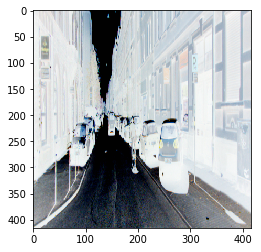

In [103]:
plt.imshow(generated_seq[0])
plt.show()